In [170]:
from __future__ import absolute_import, division, print_function
%matplotlib inline
import os
import ast
#import urllib, cStringIO

import pymongo as pm
from itertools import combinations

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image, ImageOps
import requests
from io import BytesIO
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore')

In [5]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

import svg_rendering_helpers as srh
reload(srh)

<module 'svg_rendering_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/svg_rendering_helpers.pyc'>

### load sketch features + metadata

In [6]:
reload(h)
cropping = 'no_crop'
base_path = '../../../data/features/'

path_to_feats = base_path + '{}/FEATURES_FC6_sketch.npy'.format(cropping)
path_to_meta = base_path + '{}/METADATA_sketch.csv'.format(cropping)
F = np.load(path_to_feats)
cors = np.corrcoef(F)
triu_inds = np.triu_indices(cors.shape[0], k = 1)
assert np.round(np.mean(cors[triu_inds]),2) != 1, 'F has redundant rows'
M = h.clean_up_metadata(pd.read_csv(path_to_meta))
assert F.shape[0]==M.shape[0], 'F and M are different sizes'

'''
Within-sketch analysis: 
Self-similarity and lesion analyses 
'''
path_to_feats_stroke_analysis = base_path + 'FEATURES_FC6_sketch_no-channel-norm_stroke-analysis.npy'#'FEATURES_FC6_sketch_stroke_analysis.npy'
path_to_meta_stroke_analysis = base_path + 'METADATA_sketch_stroke-analysis.csv'#'METADATA_sketch_stroke_analysis.csv'
F_stroke_analysis = np.load(path_to_feats_stroke_analysis)
M_stroke_analysis = h.clean_up_metadata(pd.read_csv(path_to_meta_stroke_analysis))

path_to_feats_self = base_path + '/self_similarity/FEATURES_FC6_sketch_no-channel-norm_stroke-analysis.npy'
path_to_meta_self = base_path + '/self_similarity/METADATA_sketch_stroke-analysis.csv'
F_self = np.load(path_to_feats_self)
M_self = h.clean_up_metadata(pd.read_csv(path_to_meta_self))

M_stroke_analysis = M_stroke_analysis.rename(index=str, columns={"direction": "num_strokes_deleted", "num_strokes_deleted": "direction"})
M_qual = M_qual.rename(index=str, columns={"direction": "num_strokes_deleted", "num_strokes_deleted": "direction"})

In [ ]:
''' Image diagnosticity analysis '''
path_to_feats_diag_56 = 'diagnosticity_56_extracted/FEATURES_vgg_FC6.npy'
path_to_meta_diag_56 = 'diagnosticity_56_extracted/METADATA.csv'
F_diag_56 = np.load(path_to_feats_diag_56)
M_diag_56 = clean_up_metadata(pd.read_csv(path_to_meta_diag_56))

path_to_feats_diag_56 = 'diagnosticity_56_intact/FEATURES_vgg_FC6.npy'
path_to_meta_diag_56 = 'diagnosticity_56_intact/METADATA.csv'
F_diag_56_intact = np.load(path_to_feats_diag_56)
M_diag_56_intact = clean_up_metadata(pd.read_csv(path_to_meta_diag_56))

In [144]:
M_diag_56 = pd.read_csv('csv/M_diag_56.csv')
M_diag_56 = M_diag_56.drop(columns=['Unnamed: 0', 'isLesioned'])

## core analyses

### 1. Between-sketch similarity analyses 

##### Within-pair convergence 
- RDM, with each cell representing dissimilarity between the sketches of two repetition numbers, averaged within target and within gameID 
- Plot similarity between sketches of `base_rep` and `base_rep + 1` against `base_rep`; shows how similarity of sketches between adjacent repetitions changes with increasing repetition

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


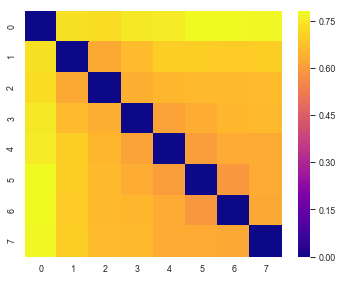

In [4]:
# create matrix for similarity between repetitions averaged within target and within game
arr_of_corrmats = h.make_adjacency_matrix(M, F, 'gameID')

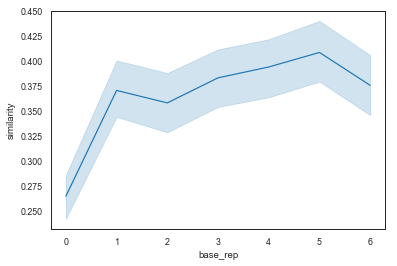

In [5]:
# plot within-pair convergence
h.plot_within_interaction_similarity(arr_of_corrmats)

##### Within-pair baseline
- For baseline, sketches are permuted across gameIDs 
- RDM, with each cell representing dissimilarity between the sketches of two repetition numbers, averaged within target and within gameID 
- Plot similarity between sketches of `base_rep` and `base_rep + 1` against `base_rep`; shows how similarity of sketches between adjacent repetitions changes with increasing repetition

/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py:837: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  M_targ_rep['pseudo_gameID'] = list(gameIDs)


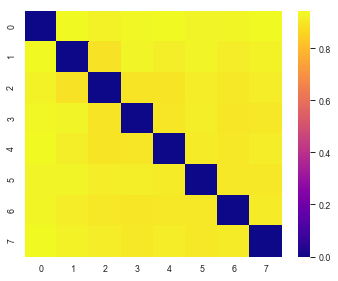

In [6]:
reload(h)
# permute across gameIDs
M_permuted_gameID = h.scramble_df_across_gameID_within_target_and_rep(M)
# create matrix for similarity between adjacent repetitions averaged within target and within game (PERMUTED)
arr_of_corrmats_permuted = h.make_adjacency_matrix(M_permuted_gameID, F, 'pseudo_gameID')

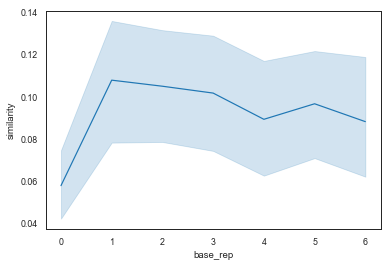

In [7]:
# plot within-pair convergence (PERMUTED)
h.plot_within_interaction_similarity(arr_of_corrmats_permuted)

##### Between-pair convergence
- Plot similarity between sketches of different gameIDs within target and within repetition 

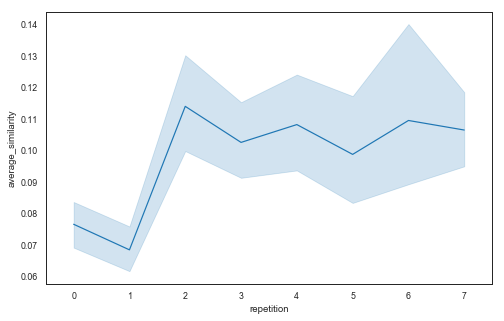

In [8]:
# plot between-pair divergence 
reload(h)
h.plot_between_interaction_similarity(M, F, 'repetition')

##### Between-pair baseline
- For baseline, sketches are permuted across repetition, but within-target and within-pair structure are preserved 

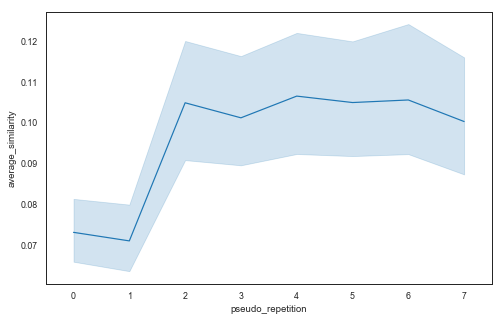

In [9]:
reload(h)
# permute across repetition 
M_permuted_rep = h.scramble_df_across_repetition_within_target_and_gameID(M)
# plot between-pair divergence (PERMUTED))
h.plot_between_interaction_similarity(M_permuted_rep, F, 'pseudo_repetition')

### 2. Within- sketch analyses 

##### First vs final stroke priority (Temporal stroke structure)
- For any pair of successive sketches, we compute baseline similarity, and see how similarity changes as we delete strokes from either the later or the earlier sketch, either in the forward or reverse direction 
- Plot similarity timecourse across stroke deletions (similarity is normalized so that baseline similarity is 1.0 and number of strokes deleted is normalized to be percentage of strokes deleted)
- Superimpose first-deleted and final-deleted to see whether it hurrts similarity more to remove from start or to remove from end 

In [249]:
D = pd.read_csv(os.path.join(results_dir, 'graphical_conventions.csv'))

In [5]:
reload(h)
# create dataframe for stroke analysis
stroke_analysis_df = h.get_stroke_analysis_df(D, M_stroke_analysis, F_stroke_analysis)

In [7]:
reload(h)
self_similarity_df = h.get_self_similarity_df(D, M_stroke_analysis, F_stroke_analysis)

In [10]:
stroke_analysis_df = pd.read_csv("csv/stroke_analysis_df.csv")
self_similarity_df = pd.read_csv("csv/self_similarity_df.csv")

In [90]:
### Computing correlation between self-similarity and length 
reload(h)
similarity_diff_list = []
length_of_strokes_deleted_list = []
for i,m in self_similarity_df.iterrows():
    similarity_diff = 1 - m['similarity']
    similarity_diff_list.append(similarity_diff)
    g = m['gameID']
    if m['target'][0] == 'w':
        t = 'waiting_' + m['target'][7:]
    else:
        t = 'dining_' + m['target'][6:]
    r = m['base_rep']
    D_ = D[(D['gameID'] == g) & (D['target'] == t) & (D['repetition'] == r)]
    svgListString = list(D_['svgString'])[0]
    arcLengths = h.getArcLengths(svgListString)
    length_of_strokes_deleted = sum([arcLengths[i] for i in range(m['num_strokes_deleted'])]) # length of first stroke 
    length_of_strokes_deleted_list.append(length_of_strokes_deleted)

In [91]:
self_similarity_df['length_of_strokes_deleted'] = length_of_strokes_deleted_list
self_similarity_df['similarity_diff'] = similarity_diff_list

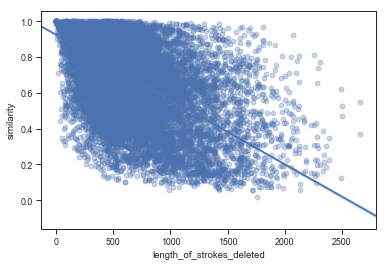

In [128]:
sns.set_context("paper")
ax = sns.regplot(x="length_of_strokes_deleted", y="similarity", scatter_kws={'alpha':0.3},#_diff
                   data=self_similarity_df)

In [119]:
from scipy import optimize
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

lm = sm.OLS.from_formula('length_of_strokes_deleted ~ similarity', self_similarity_df) #_diff
result = lm.fit()
print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     length_of_strokes_deleted   R-squared:                       0.434
Model:                                   OLS   Adj. R-squared:                  0.434
Method:                        Least Squares   F-statistic:                 1.539e+04
Date:                       Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                               22:52:16   Log-Likelihood:            -1.4456e+05
No. Observations:                      20078   AIC:                         2.891e+05
Df Residuals:                          20076   BIC:                         2.891e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [113]:
## TO DO 
# delete every stroke from whole sketch and plot similarity to whole sketch against length of stroke 
reload(h)
one_deleted_df = h.get_one_deleted_df(D, M_self, F_self, M_stroke_analysis, F_stroke_analysis)

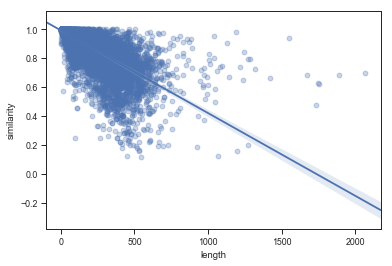

In [129]:
sns.set_context("paper")
ax = sns.regplot(x="length", y="similarity", scatter_kws={'alpha':0.3},#_diff
                   data=one_deleted_df)

In [117]:
from scipy import optimize
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

lm = sm.OLS.from_formula('length ~ similarity', one_deleted_df) #_diff
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.084e+04
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:51:50   Log-Likelihood:                -69120.
No. Observations:               11225   AIC:                         1.382e+05
Df Residuals:                   11223   BIC:                         1.383e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    934.9818      7.484    124.939      0.0

##### Plotting for each repetition pair e.g. rep0 and rep1, rep1 and rep2, etc. (continous)

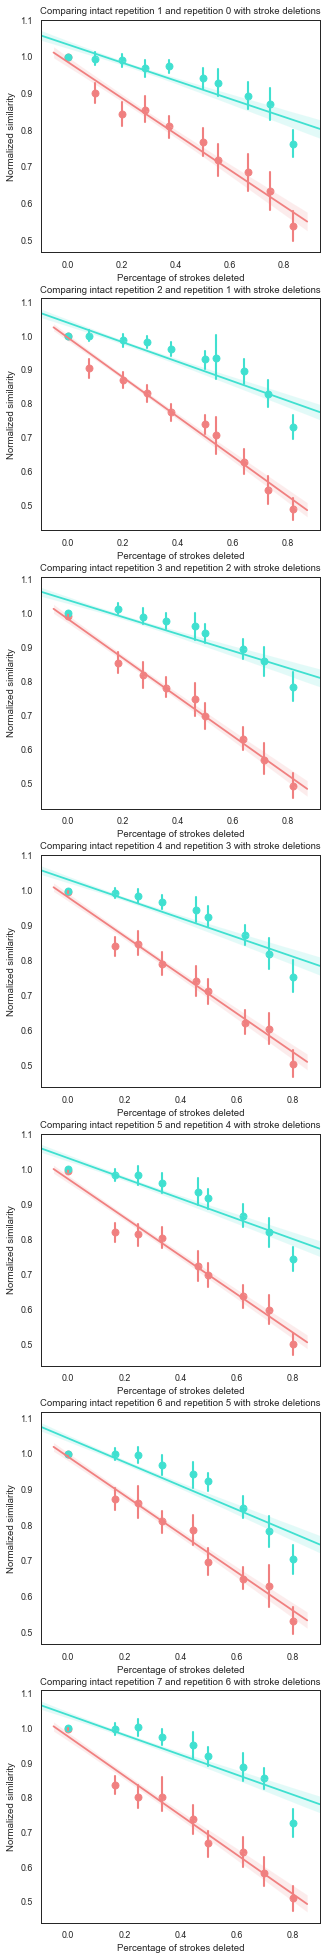

In [113]:
reload(h)
# lesion earlier sketch 
sns.set_context("paper")
fig, axs = plt.subplots(nrows=7, figsize=(5,35))
h.plot_stroke_similarity_rep_specific(stroke_analysis_df, False, axs)

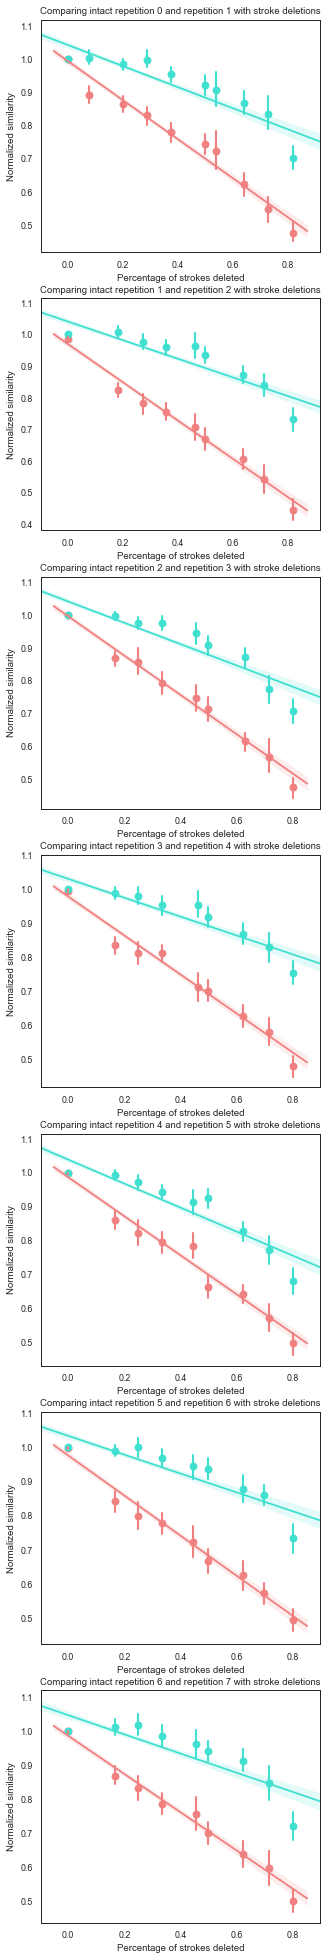

In [114]:
# lesion later sketch 
sns.set_context("paper")
fig, axs = plt.subplots(nrows=7, figsize=(5,35))
h.plot_stroke_similarity_rep_specific(stroke_analysis_df,True, axs)

In [267]:
### Self-similarity PLUS sketches
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py'>

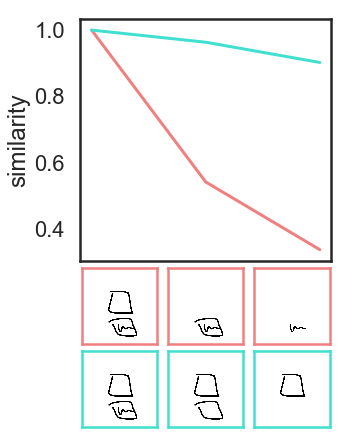

In [268]:
png_name = 'run3_0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d_6_repeated_waiting_03_0_end_0.png'
h.plot_self_similarity_of(self_similarity_df, sketch_dir, png_name)

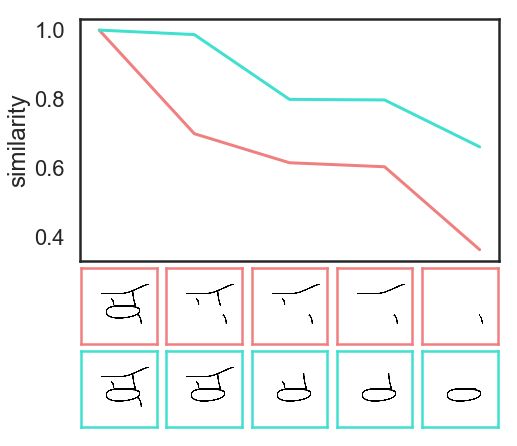

In [308]:
png_name = 'run3_0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d_13_repeated_waiting_07_2_start_4.png'
h.plot_self_similarity_of(self_similarity_df, sketch_dir, png_name)

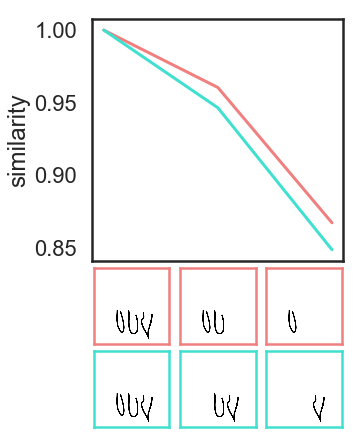

In [309]:
png_name = 'run3_0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d_22_repeated_waiting_00_4_end_2.png'
h.plot_self_similarity_of(self_similarity_df, sketch_dir, png_name)

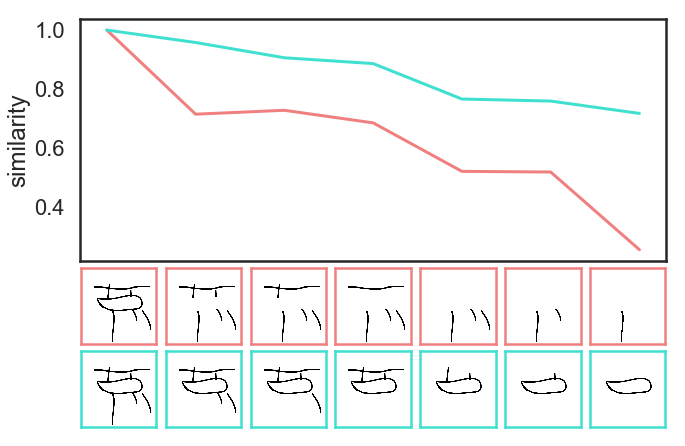

In [271]:
png_name = 'run3_0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d_28_repeated_waiting_07_5_end_3.png'
h.plot_self_similarity_of(self_similarity_df, sketch_dir, png_name)

### Coloring strokes by importance

In [ ]:
png_name = 'run3_0286-a442ec93-ad78-42fa-b3e9-083da9a64c4d_28_repeated_waiting_07_5_end_3.png'
h.get_stroke_importance(self_similarity_df, sketch_dir, png_name)

### Image diagnosticity

##### 16 chairs (diningA, diningB, diningC, diningD)

In [10]:
# Load Shapenet dict 
shapenets = h.shapenets 

shapenet_names = [shapenet['filename'].split('.')[0] for shapenet in shapenets]
shapenet_names.sort()

# contexts used in refgame 
diningA = ['30afd2ef2ed30238aa3d0a2f00b54836', '30dc9d9cfbc01e19950c1f85d919ebc2', '56262eebe592b085d319c38340319ae4', '3d7ebe5de86294b3f6bcd046624c43c9']
diningB = ['4c1777173111f2e380a88936375f2ef4', '3466b6ecd040e252c215f685ba622927', '38f87e02e850d3bd1d5ccc40b510e4bd', '3cf6db91f872d26c222659d33fd79709']
waitingA = ['1d1641362ad5a34ac3bd24f986301745', '1da9942b2ab7082b2ba1fdc12ecb5c9e', '2eaab78d6e4c4f2d7b0c85d2effc7e09', '309674bdec2d24d7597976c675750537']
waitingB = ['23b0da45f23e5fb4f4b6538438a0b930', '2b5953c986dd08f2f91663a74ccd2338', '2e291f35746e94fa62762c7262e78952', '2448d9aeda5bb9b0f4b6538438a0b930']

##### Rendering lesioned and non-lesioned images of each chair

In [42]:
# For each image, pad by pad, move a box_size x box_size window and render versions with that box lesioned 
h.render_lesioned_images(pad=28, box_size=56)

rendering lesioned version of 30afd2ef2ed30238aa3d0a2f00b54836
rendering lesioned version of 30dc9d9cfbc01e19950c1f85d919ebc2
rendering lesioned version of 4c1777173111f2e380a88936375f2ef4
rendering lesioned version of 3466b6ecd040e252c215f685ba622927
rendering lesioned version of 38f87e02e850d3bd1d5ccc40b510e4bd
rendering lesioned version of 3cf6db91f872d26c222659d33fd79709
rendering lesioned version of 3d7ebe5de86294b3f6bcd046624c43c9
rendering lesioned version of 56262eebe592b085d319c38340319ae4
rendering lesioned version of 1d1641362ad5a34ac3bd24f986301745
rendering lesioned version of 1da9942b2ab7082b2ba1fdc12ecb5c9e
rendering lesioned version of 2448d9aeda5bb9b0f4b6538438a0b930
rendering lesioned version of 23b0da45f23e5fb4f4b6538438a0b930
rendering lesioned version of 2b5953c986dd08f2f91663a74ccd2338
rendering lesioned version of 2e291f35746e94fa62762c7262e78952
rendering lesioned version of 2eaab78d6e4c4f2d7b0c85d2effc7e09
rendering lesioned version of 309674bdec2d24d7597976c67

##### Create df with pairwise similarities of lesioned and non-lesioned chairs 

In [ ]:
# load saved csv 
lesion_image_df = pd.read_csv("csv/lesion_image_df.csv")
diagnosticity_df = pd.read_csv("csv/diagnosticity_df.csv")
diag_df = pd.read_csv('diagnosticity_df.csv')

In [ ]:
# new: with padding of 28: 
M_diag_56 = M_diag_56.drop(columns=['Unnamed: 0', 'isLesioned'])
M_diag_56.sort_values(by=['shapenet', 'x', 'y'], inplace=True)
M_arr = np.array(M_diag_56) 
lesion_image_arr_df = pd.read_csv('lesion_image_arr_df.csv')

getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 1da9942b2ab7082b2ba1fdc12ecb5c9e
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 23b0da45f23e5fb4f4b6538438a0b930
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 23b0da45f23e5fb4f4b6538438a0b930
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2448d9aeda5bb9b0f4b6538438a0b930


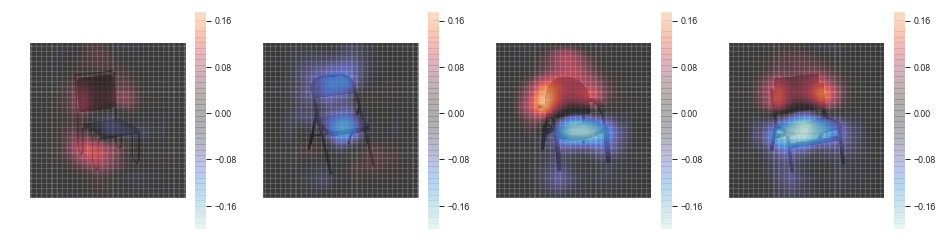

In [282]:
reload(h)
h.plot_heatmaps(lesion_image_arr_df, shapenet_names[:4], 28, 56)

getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 4c1777173111f2e380a88936375f2ef4


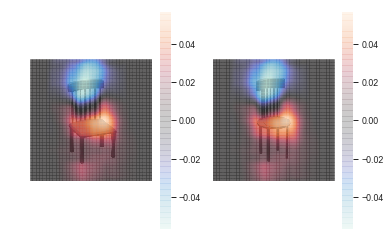

In [200]:
reload(h)
h.plot_heatmaps(lesion_image_arr_df, [shapenet_names[8], shapenet_names[14]], 28, 56)

getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2e291f35746e94fa62762c7262e78952


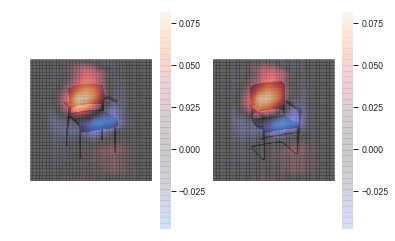

In [205]:
reload(h)
h.plot_heatmaps(lesion_image_arr_df, [shapenet_names[4], shapenet_names[5]], 28, 56)

getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 30dc9d9cfbc01e19950c1f85d919ebc2
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 38f87e02e850d3bd1d5ccc40b510e4bd


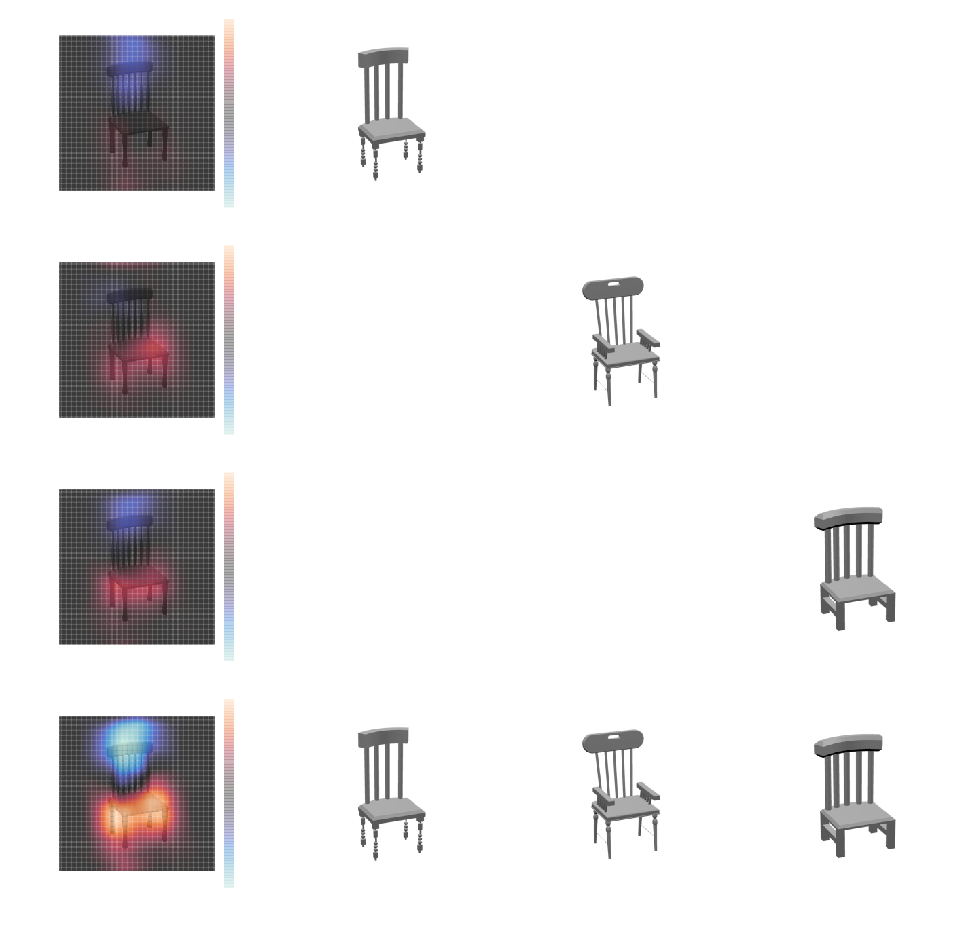

In [256]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(shapenet_names[8:12], 0, 28, 56, lesion_image_arr_df) 

In [259]:
### CONTEXTS WE HAVE USED 

getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 30dc9d9cfbc01e19950c1f85d919ebc2
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 3d7ebe5de86294b3f6bcd046624c43c9


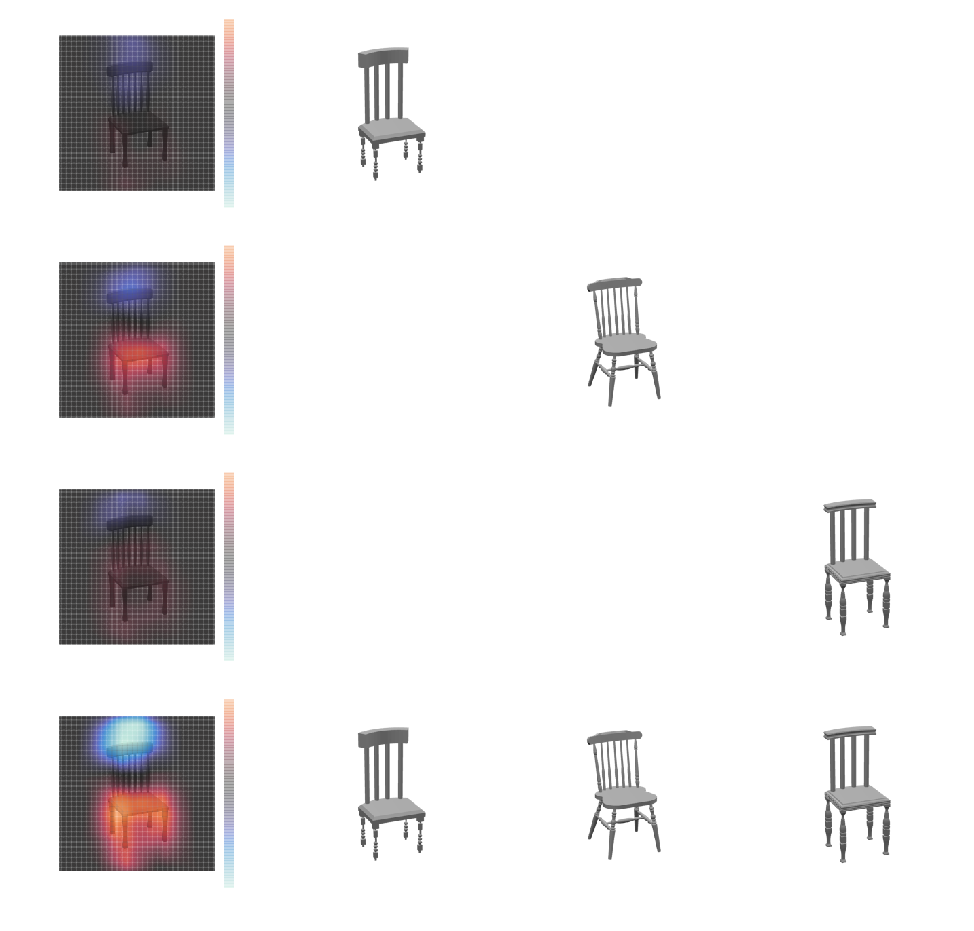

In [261]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningA, 0, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 30dc9d9cfbc01e19950c1f85d919ebc2
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 3d7ebe5de86294b3f6bcd046624c43c9


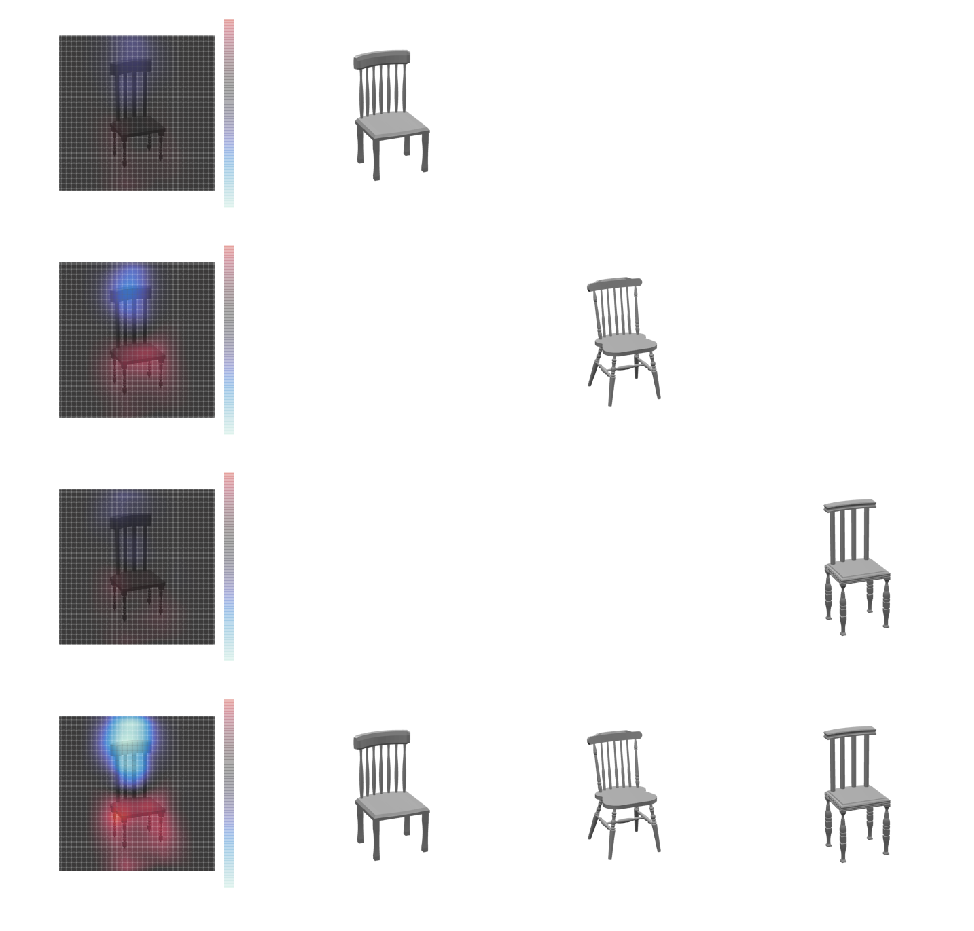

In [264]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningA, 1, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 30dc9d9cfbc01e19950c1f85d919ebc2
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 3d7ebe5de86294b3f6bcd046624c43c9


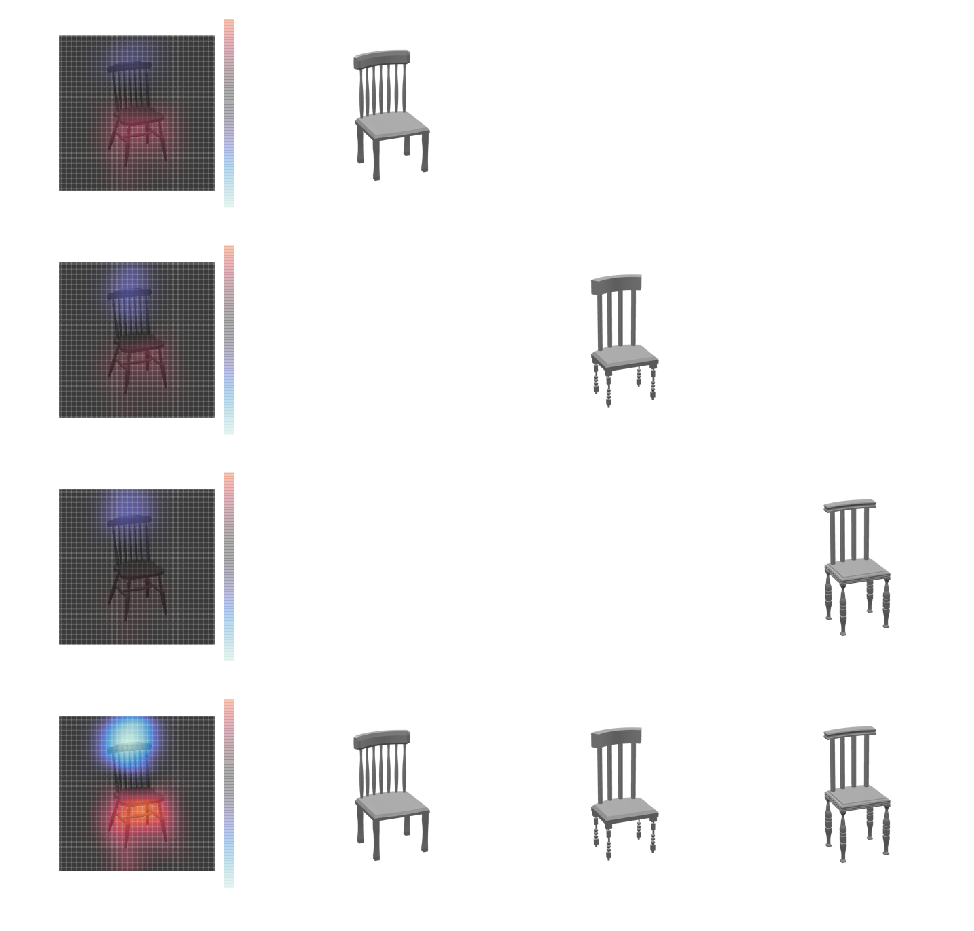

In [265]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningA, 2, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 30dc9d9cfbc01e19950c1f85d919ebc2
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30afd2ef2ed30238aa3d0a2f00b54836 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 3d7ebe5de86294b3f6bcd046624c43c9
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 3d7ebe5de86294b3f6bcd046624c43c9


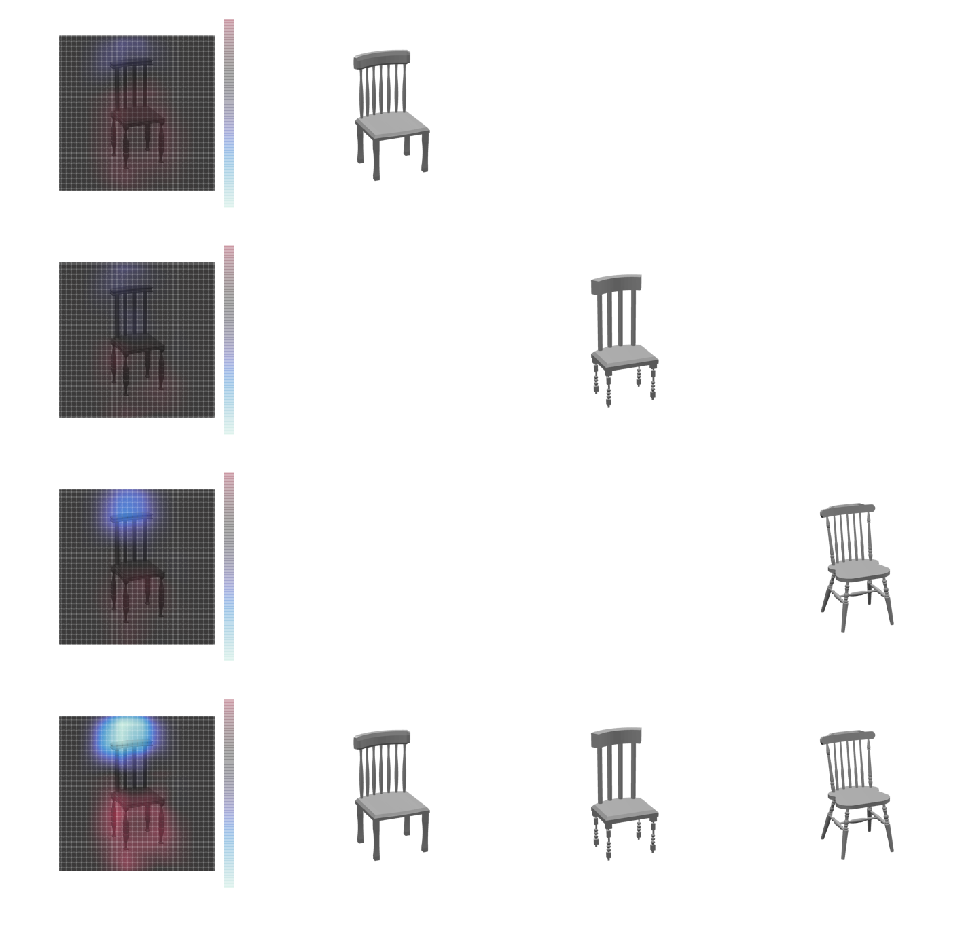

In [266]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningA, 3, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 38f87e02e850d3bd1d5ccc40b510e4bd and 3cf6db91f872d26c222659d33fd79709


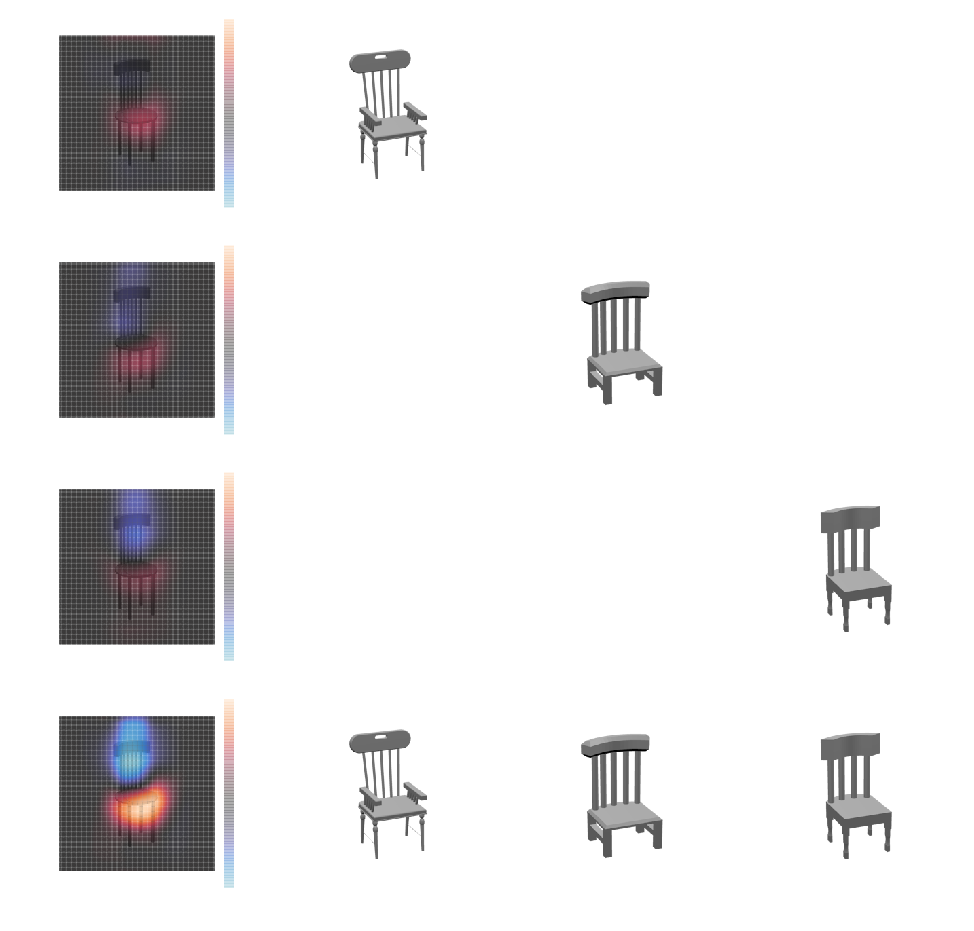

In [262]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningB, 0, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 38f87e02e850d3bd1d5ccc40b510e4bd and 3cf6db91f872d26c222659d33fd79709


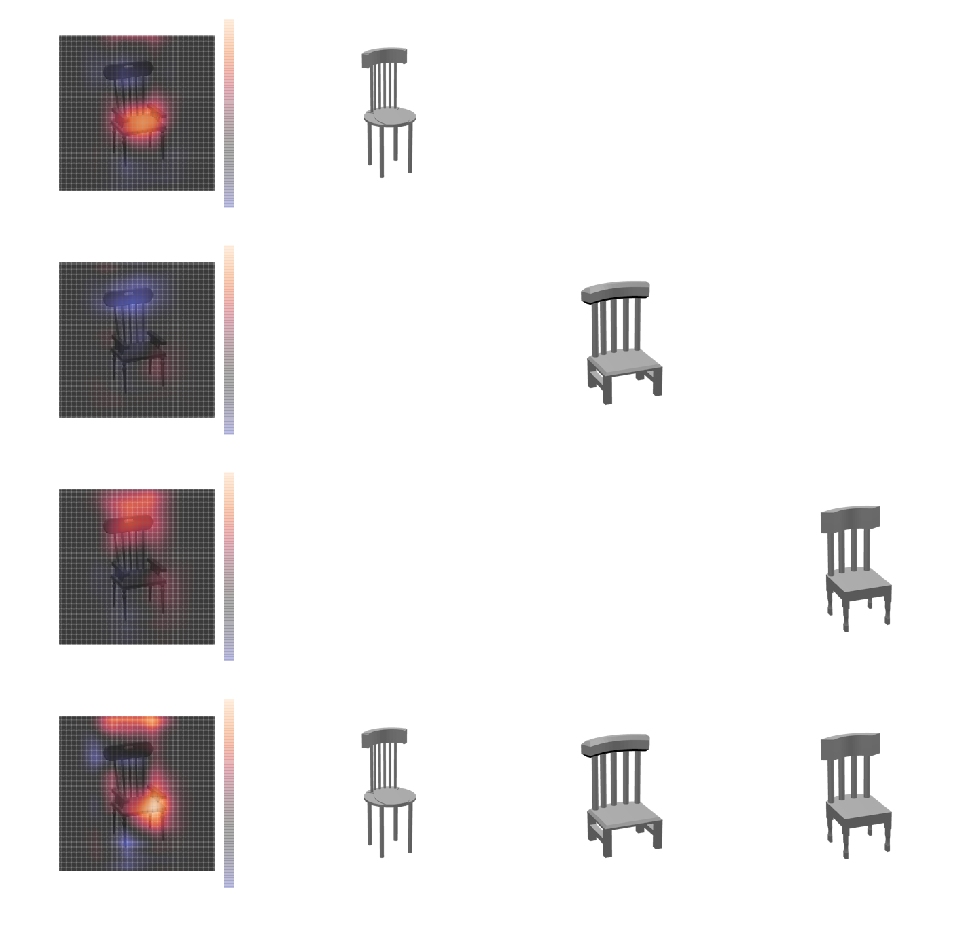

In [267]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningB, 1, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 38f87e02e850d3bd1d5ccc40b510e4bd and 3cf6db91f872d26c222659d33fd79709


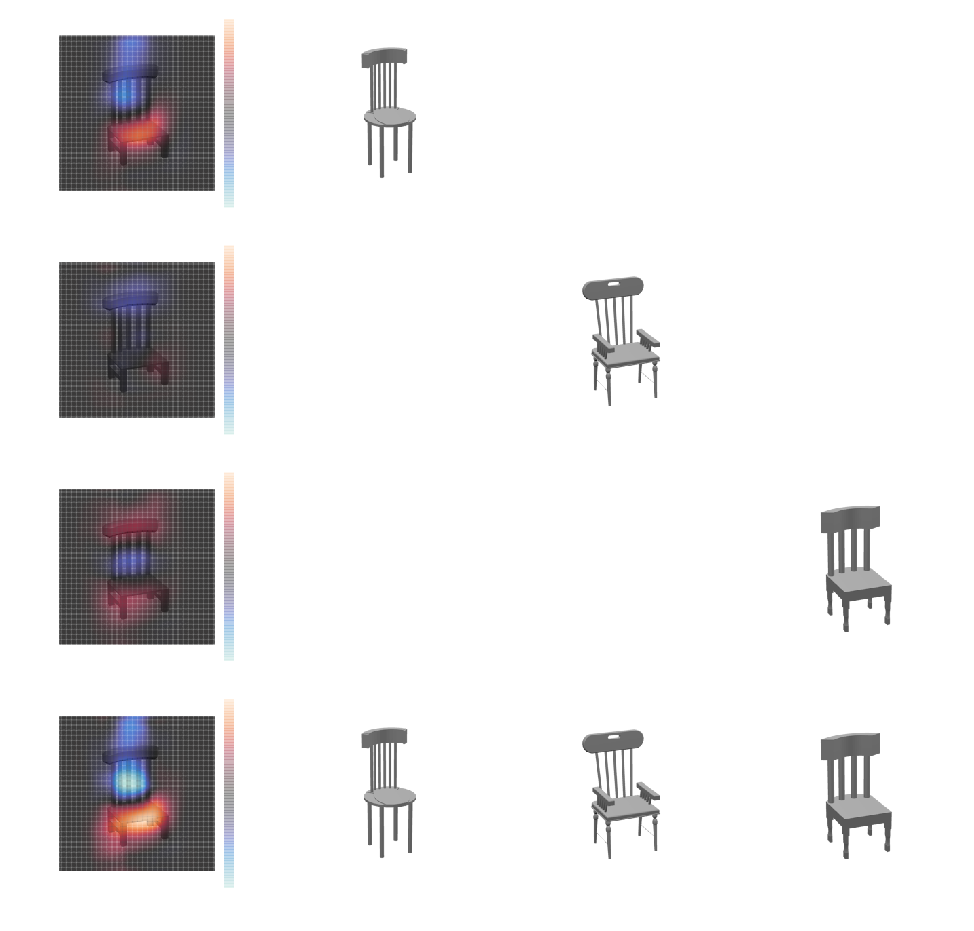

In [268]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningB, 2, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 3cf6db91f872d26c222659d33fd79709
getting heatmap for pair: 38f87e02e850d3bd1d5ccc40b510e4bd and 3cf6db91f872d26c222659d33fd79709


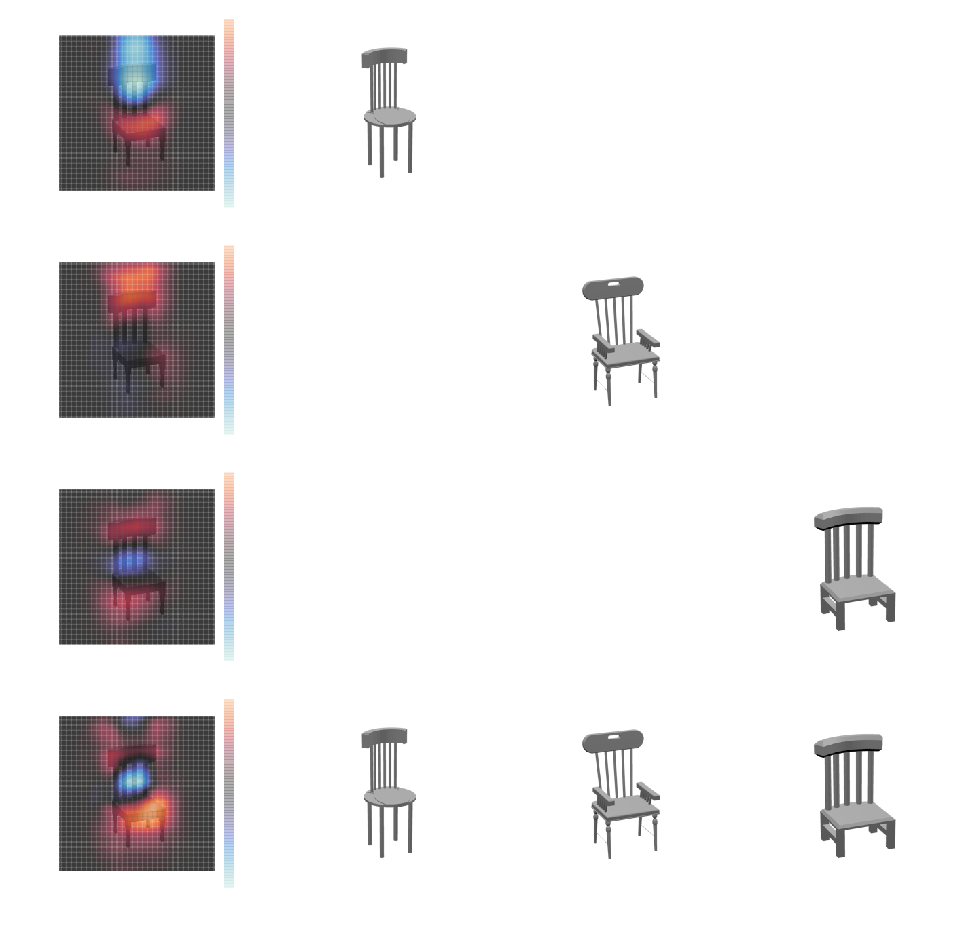

In [269]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(diningB, 3, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 1da9942b2ab7082b2ba1fdc12ecb5c9e
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 2eaab78d6e4c4f2d7b0c85d2effc7e09 and 309674bdec2d24d7597976c675750537


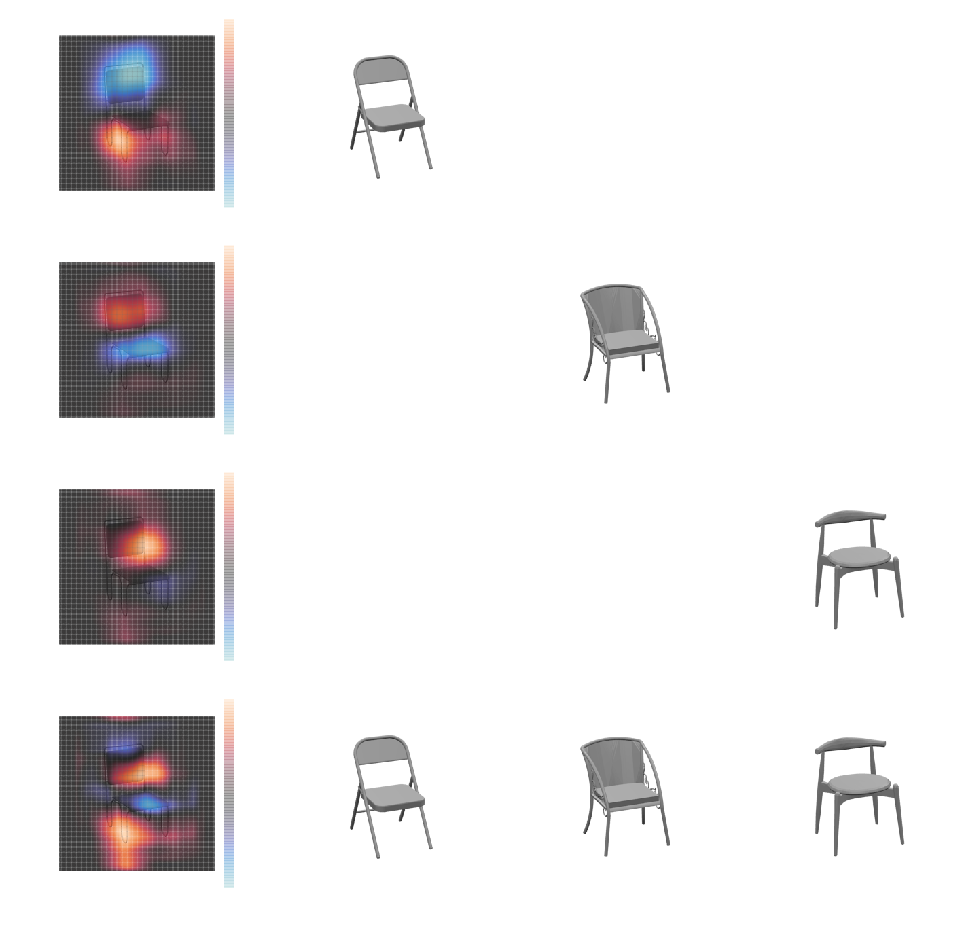

In [263]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingA, 0, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 1da9942b2ab7082b2ba1fdc12ecb5c9e
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 2eaab78d6e4c4f2d7b0c85d2effc7e09 and 309674bdec2d24d7597976c675750537


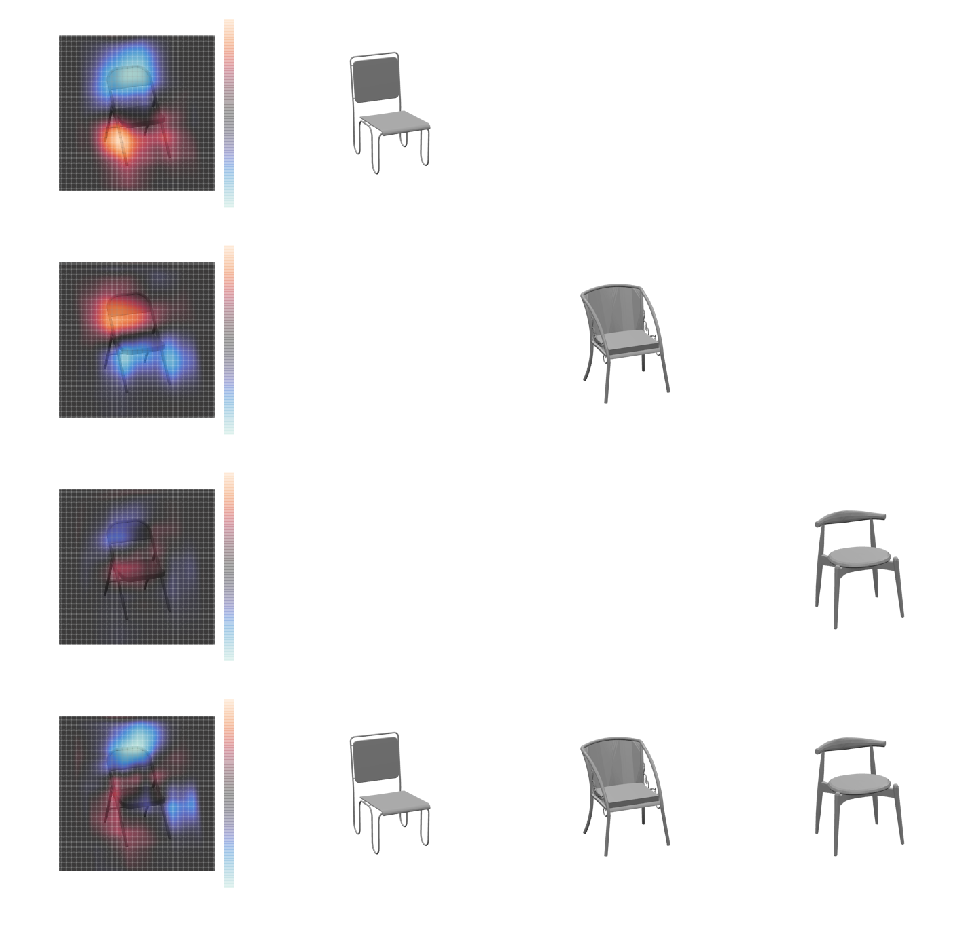

In [270]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingA, 1, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 1da9942b2ab7082b2ba1fdc12ecb5c9e
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 2eaab78d6e4c4f2d7b0c85d2effc7e09 and 309674bdec2d24d7597976c675750537


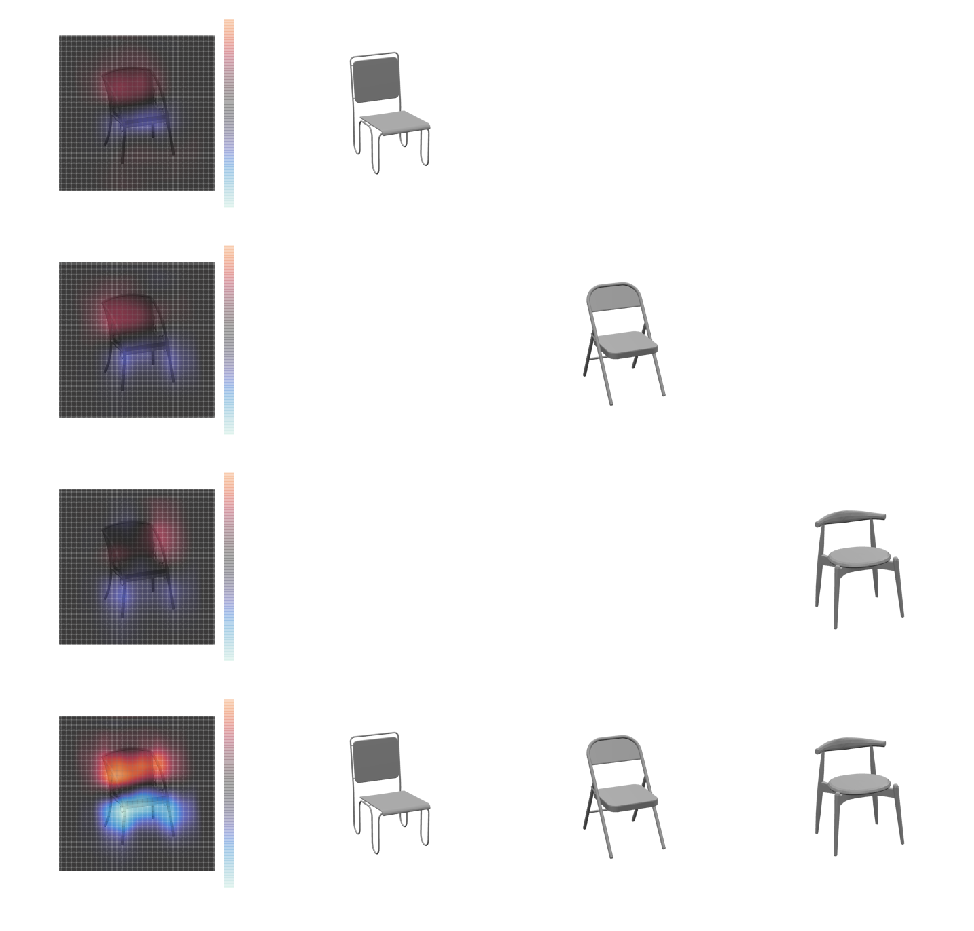

In [271]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingA, 2, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 1da9942b2ab7082b2ba1fdc12ecb5c9e
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1d1641362ad5a34ac3bd24f986301745 and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 2eaab78d6e4c4f2d7b0c85d2effc7e09
getting heatmap for pair: 1da9942b2ab7082b2ba1fdc12ecb5c9e and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 2eaab78d6e4c4f2d7b0c85d2effc7e09 and 309674bdec2d24d7597976c675750537


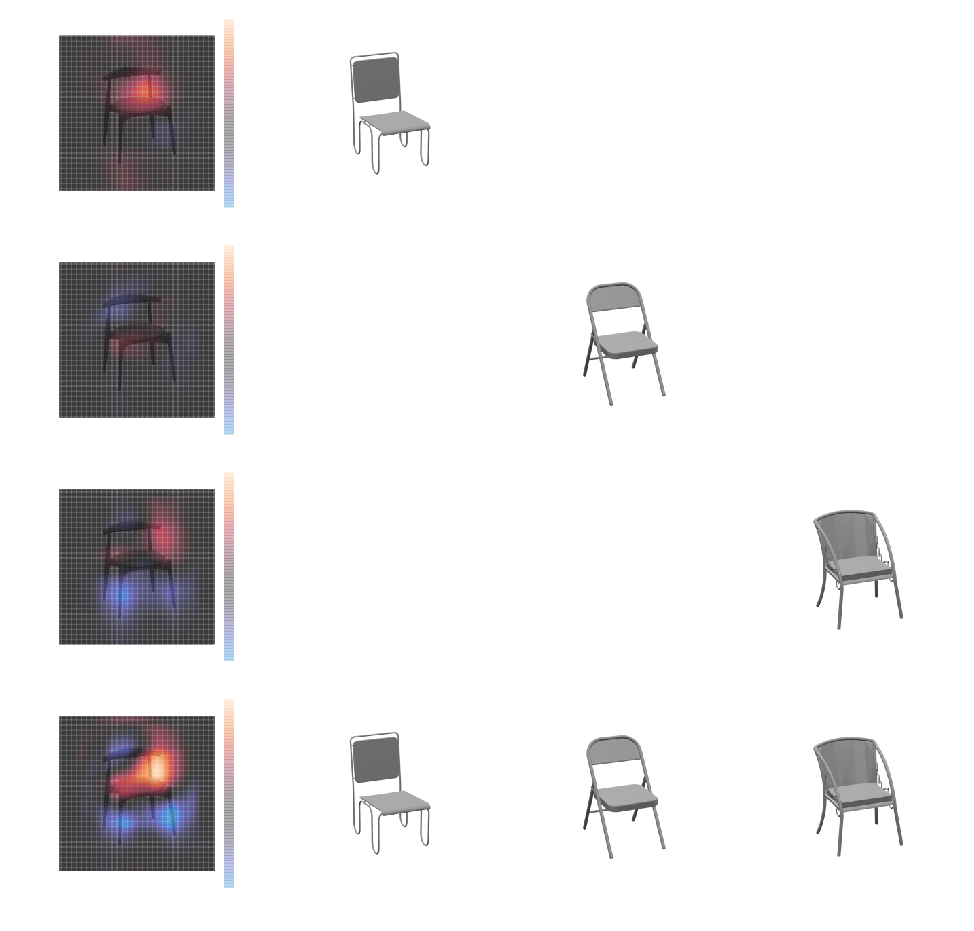

In [272]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingA, 3, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2b5953c986dd08f2f91663a74ccd2338
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2e291f35746e94fa62762c7262e78952 and 2448d9aeda5bb9b0f4b6538438a0b930


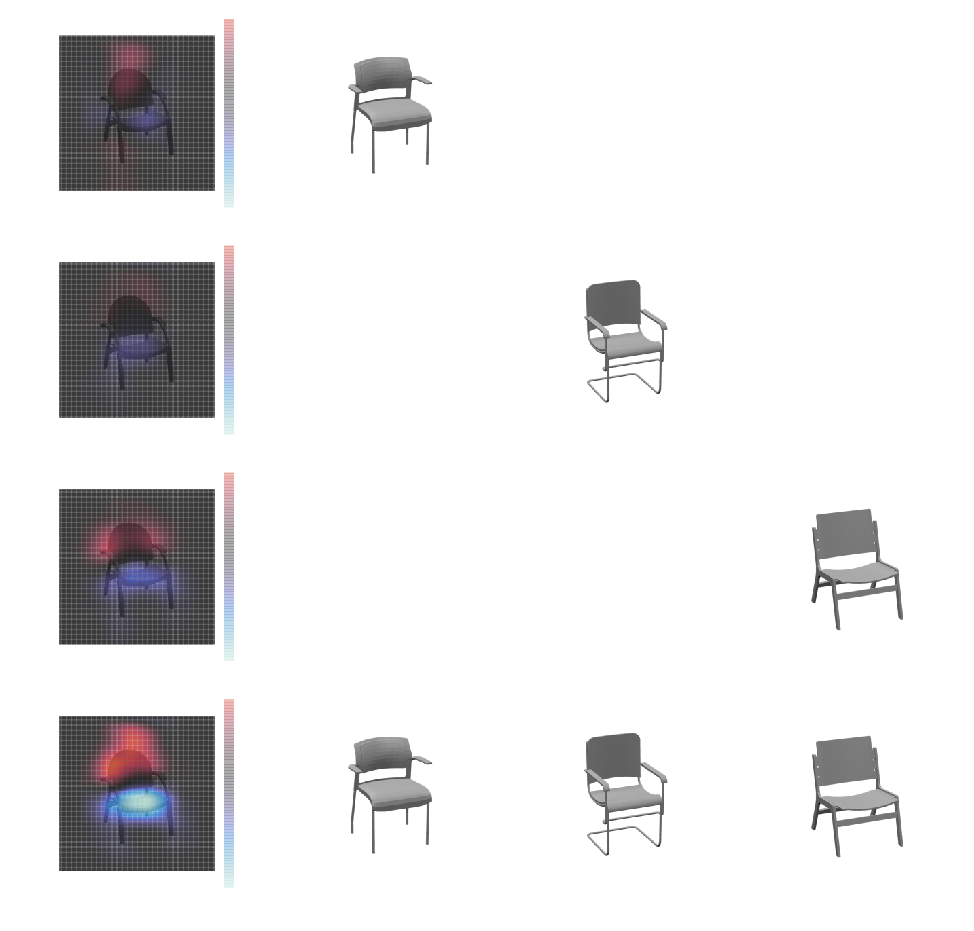

In [273]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingB, 0, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2b5953c986dd08f2f91663a74ccd2338
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2e291f35746e94fa62762c7262e78952 and 2448d9aeda5bb9b0f4b6538438a0b930


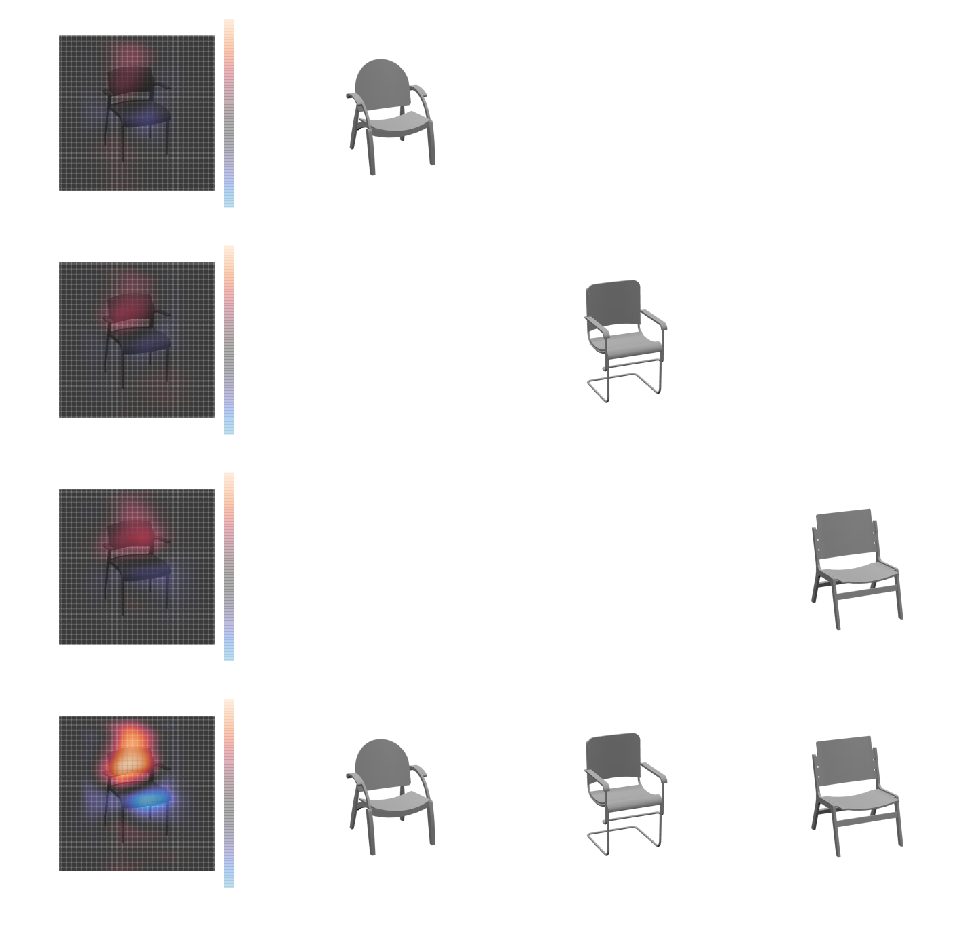

In [274]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingB, 1, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2b5953c986dd08f2f91663a74ccd2338
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2e291f35746e94fa62762c7262e78952 and 2448d9aeda5bb9b0f4b6538438a0b930


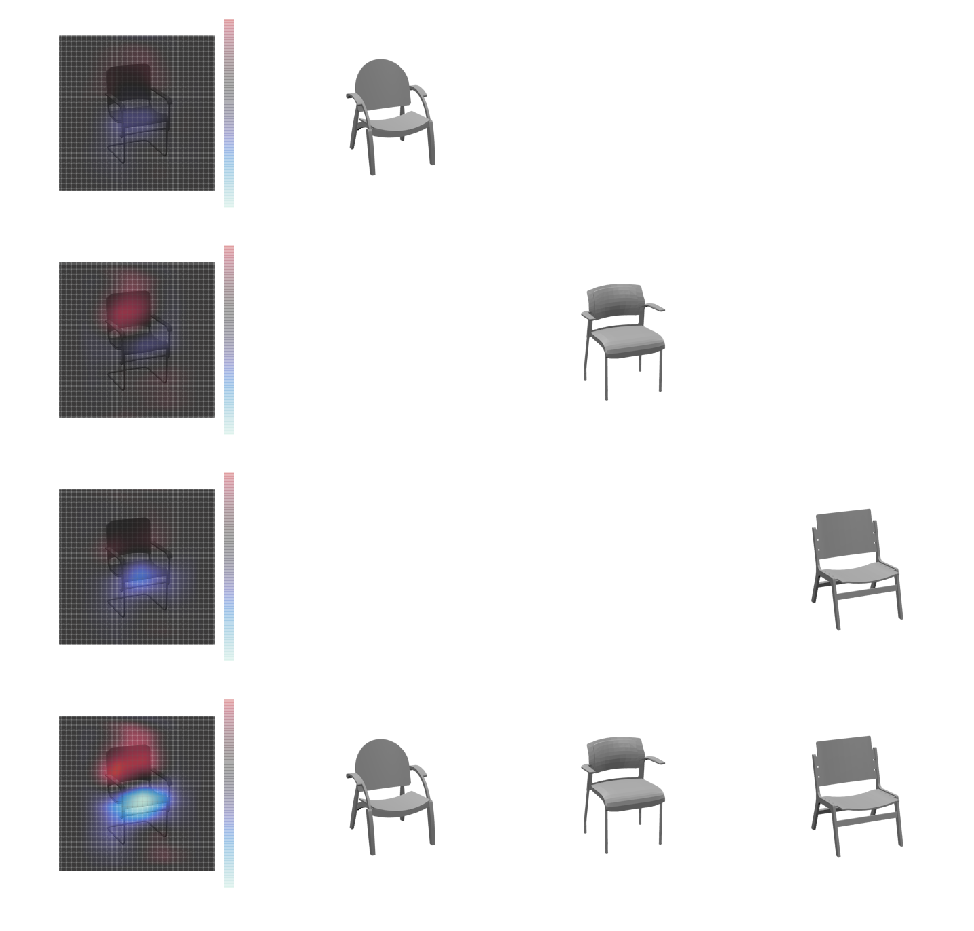

In [275]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingB, 2, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2b5953c986dd08f2f91663a74ccd2338
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 23b0da45f23e5fb4f4b6538438a0b930 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2e291f35746e94fa62762c7262e78952
getting heatmap for pair: 2b5953c986dd08f2f91663a74ccd2338 and 2448d9aeda5bb9b0f4b6538438a0b930
getting heatmap for pair: 2e291f35746e94fa62762c7262e78952 and 2448d9aeda5bb9b0f4b6538438a0b930


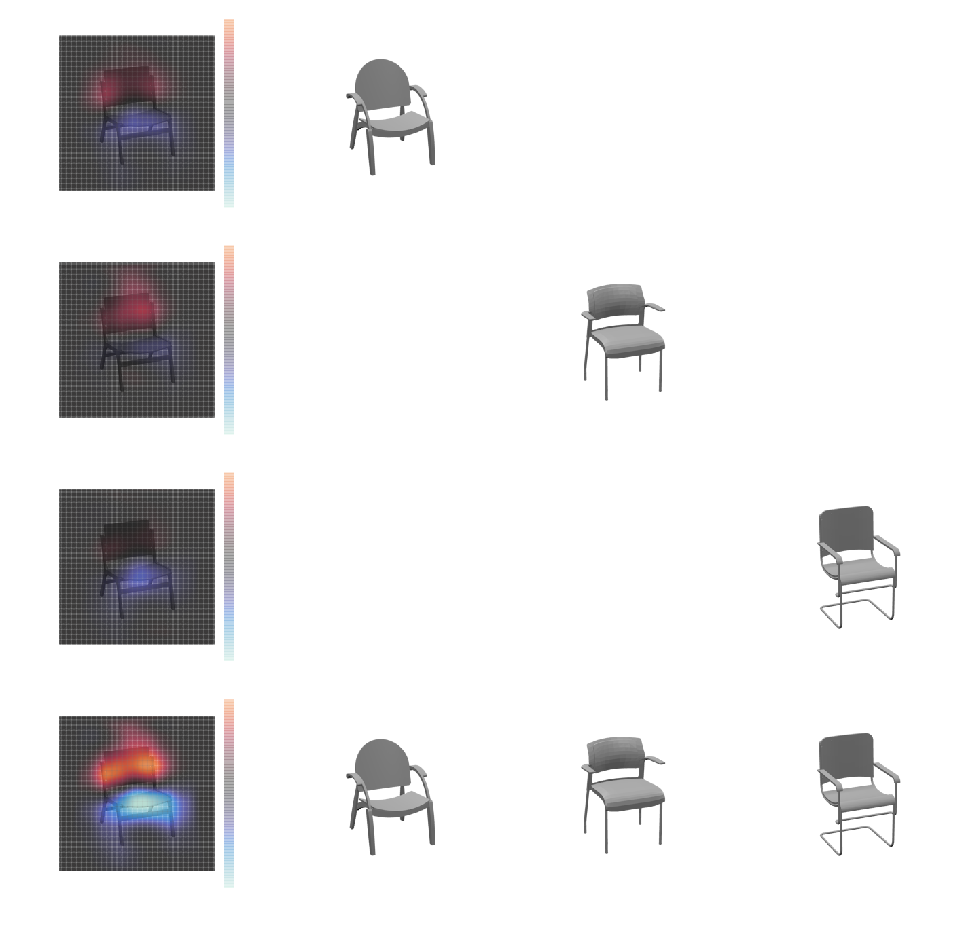

In [276]:
reload(h)
all_heatmaps = h.plot_heatmaps_complete(waitingB, 3, 28, 56, lesion_image_arr_df) 

getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 30dc9d9cfbc01e19950c1f85d919ebc2 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 3466b6ecd040e252c215f685ba622927
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 38f87e02e850d3bd1d5ccc40b510e4bd
getting heatmap for pair: 3466b6ecd040e252c215f685ba622927 and 38f87e02e850d3bd1d5ccc40b510e4bd


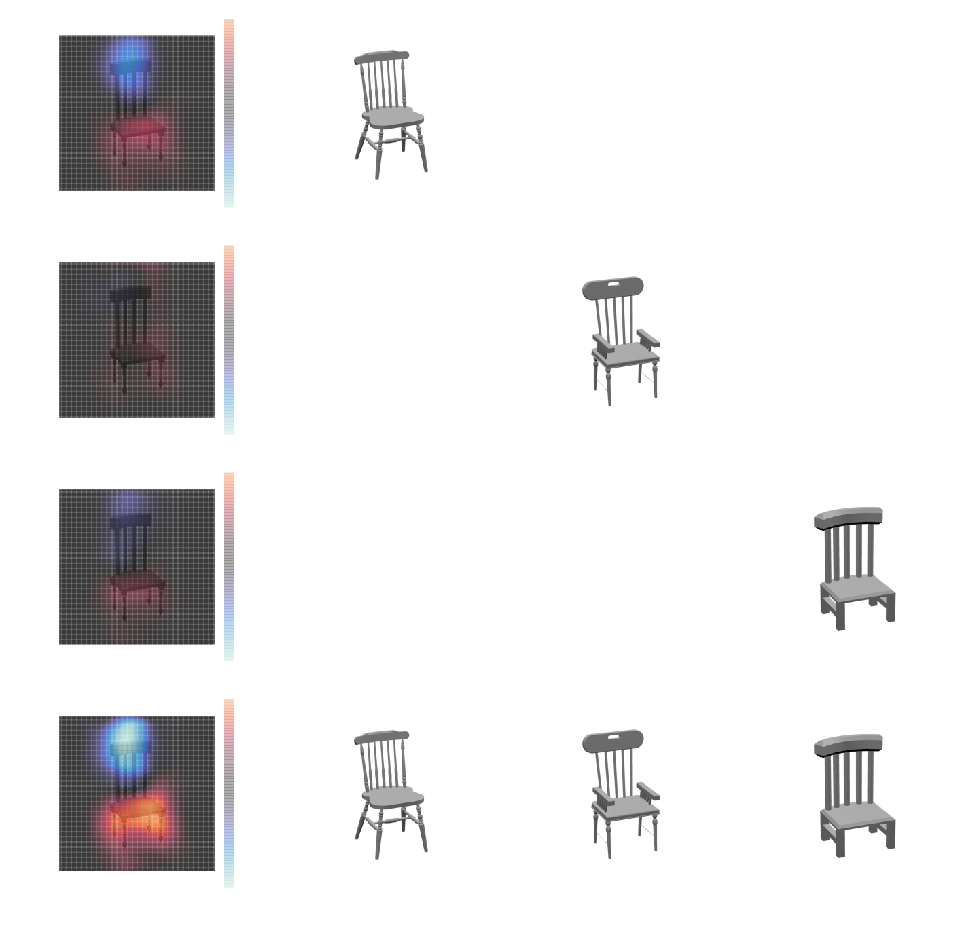

In [278]:
reload(h)
similars = ['30dc9d9cfbc01e19950c1f85d919ebc2', '56262eebe592b085d319c38340319ae4', '3466b6ecd040e252c215f685ba622927', '38f87e02e850d3bd1d5ccc40b510e4bd']
all_heatmaps = h.plot_heatmaps_complete(similars, 0, 28, 56, lesion_image_arr_df)

getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 56262eebe592b085d319c38340319ae4
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 4c1777173111f2e380a88936375f2ef4 and 2b5953c986dd08f2f91663a74ccd2338
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 309674bdec2d24d7597976c675750537
getting heatmap for pair: 56262eebe592b085d319c38340319ae4 and 2b5953c986dd08f2f91663a74ccd2338
getting heatmap for pair: 309674bdec2d24d7597976c675750537 and 2b5953c986dd08f2f91663a74ccd2338


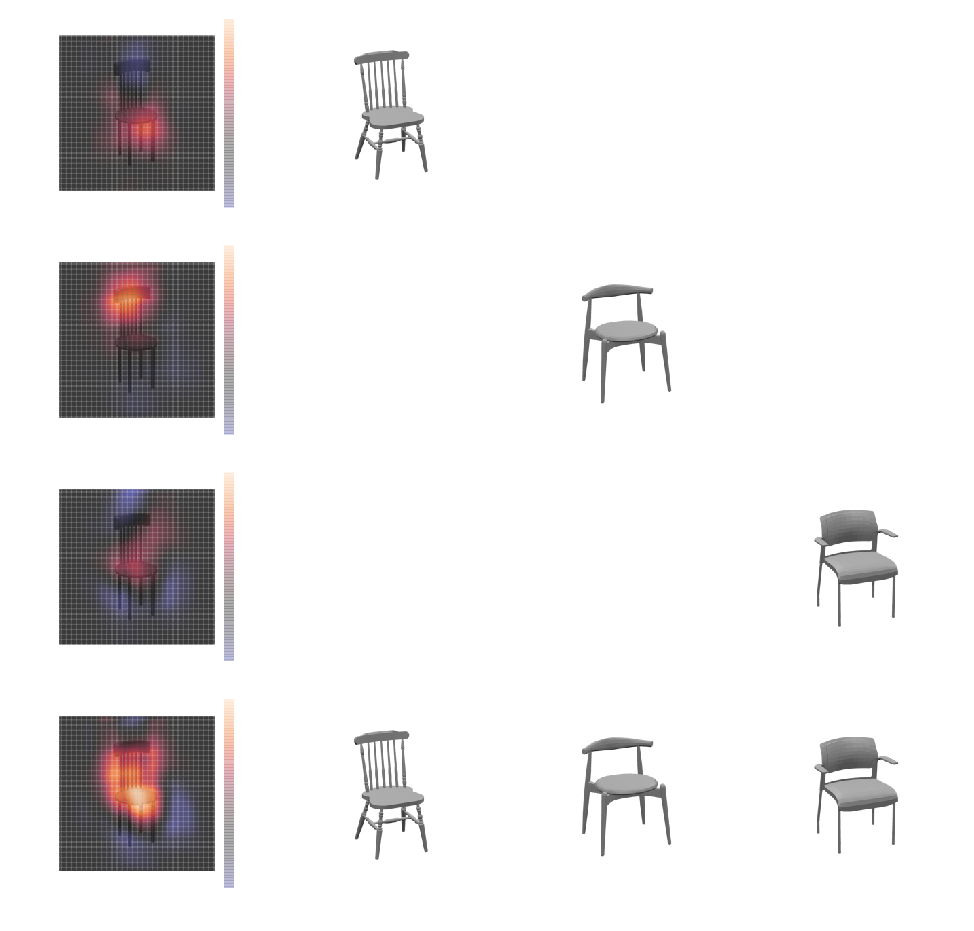

In [279]:
reload(h)
extremes = ['4c1777173111f2e380a88936375f2ef4', '56262eebe592b085d319c38340319ae4', '309674bdec2d24d7597976c675750537', '2b5953c986dd08f2f91663a74ccd2338']
all_heatmaps = h.plot_heatmaps_complete(extremes, 0, 28, 56, lesion_image_arr_df)

In [75]:
def get_lesion_image_df_vectorized(M, F, F_):
    '''
    To be able to compute \sum_i (sim(o’, d_i’) - sim(o, d_i)) later, we want a dataframe we can look 
    up using two shapenet IDs and an isLesioned indicator to get similarity between them 
    
    Input: M (meta dataframe: lesioned images and corresponding feature inds), F (features) 
    Output: Similarity between two lesioned images and similarity between intact images? 
    
    Resulting dataframe should have columns: (shapenet1, shapenet2), isLesioned, similarity 
    '''
    M.sort_values(by=['shapenet', 'x', 'y'], inplace=True)
    M_arr = np.transpose(np.array(M))
    #M_.sort_values(by=['shapenet', 'x', 'y'], inplace=True)
    # processing on M_ 
    #M_arr = np.reshape(M_arr, (16, 50625)) # ALSO SORT IN ADVANCE BY X AND Y VALUES (1)
    
    lesion_image_arr = np.zeros((120 * 50626,)) # shapenet pair, isLesioned, 
    # this list should be 120 long 
    pair_num = -1 
    pair_num_dict = {}
    for i, shapenet1 in enumerate(shapenet_names):
        for j, shapenet2 in enumerate(shapenet_names):
            if i < j:
                pair_num += 1 
                print("pair num: {}".format(pair_num))
                print("shapenet1: {}, shapenet2: {}".format(shapenet1, shapenet2))
                for x in range(225):
                    for y in range(225):
                        feature_ind_index1 = i * 50625 + x * 225 + y 
                        feature_ind_index2 = j * 50625 + x * 225 + y 
                        feature_ind1 = M_arr[3][feature_ind_index1]
                        feature_ind2 = M_arr[3][feature_ind_index2]
                        # lesion_image_arr[pair_num][x][y] = h.compute_similarity(F, [feature_ind1, feature_ind2])# AHHH 
                        lesion_image_arr[pair_num * 50626 + x * 225 + y] = h.compute_similarity(F, [feature_ind1, feature_ind2])# AHHH 
                        pair_num_dict[(shapenet1, shapenet2)] = pair_num 
                lesion_image_arr[pair_num * 50626 + 50625] = h.compute_similarity(F_, [i,j])# AHHH   
    lesion_image_arr_df = pd.DataFrame()
    lesion_image_arr_df['pair_num'] = np.repeat(np.array(range(120)), 50626) 
    lesion_image_arr_df['x'] = np.tile(np.concatenate((np.repeat(np.array(range(225)), 225), np.array([0]))), 120)
    lesion_image_arr_df['y'] = np.tile(np.concatenate((np.tile(np.array(range(225)), 225), np.array([0]))), 120)
    lesion_image_arr_df['similarity'] = lesion_image_arr 
    lesion_image_arr_df.to_csv('lesion_image_arr_df.csv')
    return lesion_image_arr_df 
M = M_diag_56
F = F_diag_56
F_ = F_diag_56_intact 
lesion_image_arr_df = get_image_lesion_df_vectorized(M_diag_56, F_diag_56, F_diag_56_intact)

### Self-Similarity

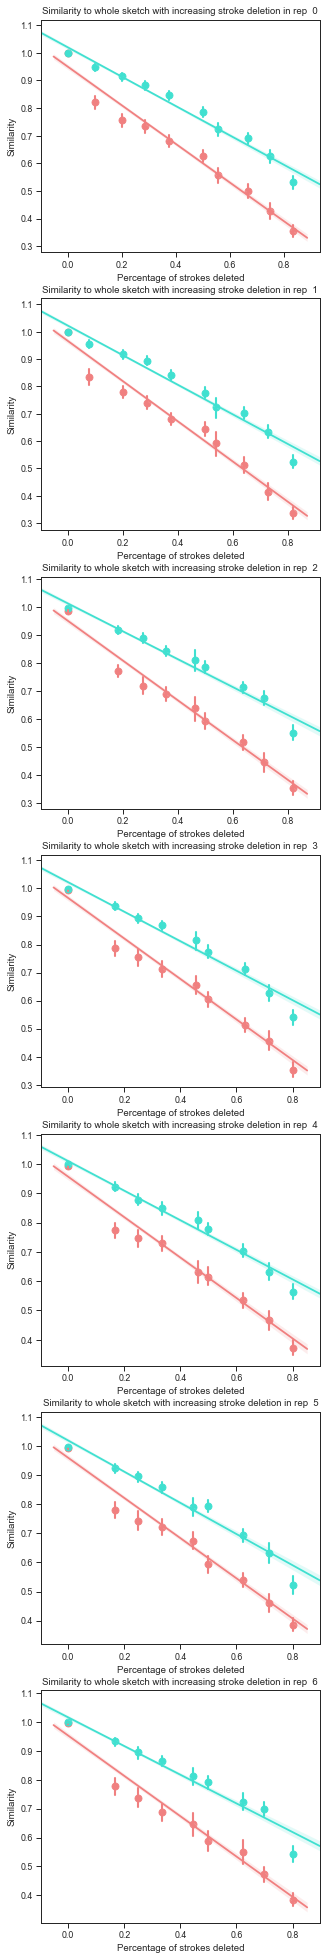

In [130]:
### Self-similarity aggregated 
fig, axs = plt.subplots(nrows=7, figsize=(5,35))
reload(h)
h.plot_self_similarity(self_similarity_df, axs)

##### Aggregating across repetition pairs (continuous)

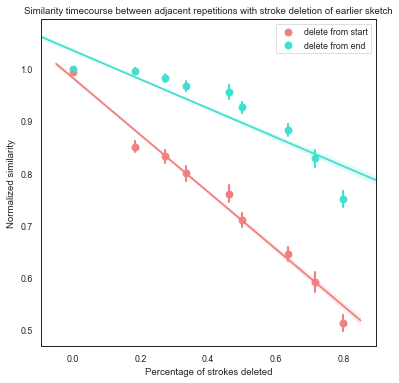

In [33]:
# lesion earlier sketch 
reload(h)
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(6, 6))
h.plot_stroke_similarity_rep_aggregate(stroke_analysis_df, False, ax)

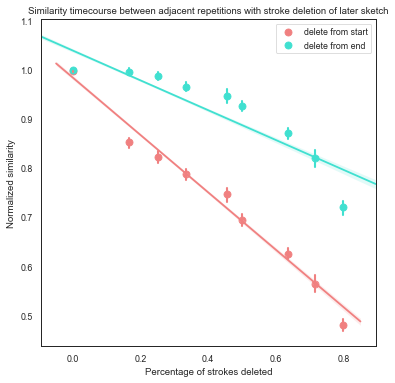

In [148]:
# lesion later sketch 
reload(h)
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(6, 6))
h.plot_stroke_similarity_rep_aggregate(stroke_analysis_df, True, ax)

##### With facets corresponding to total number of strokes in sketch (discrete)

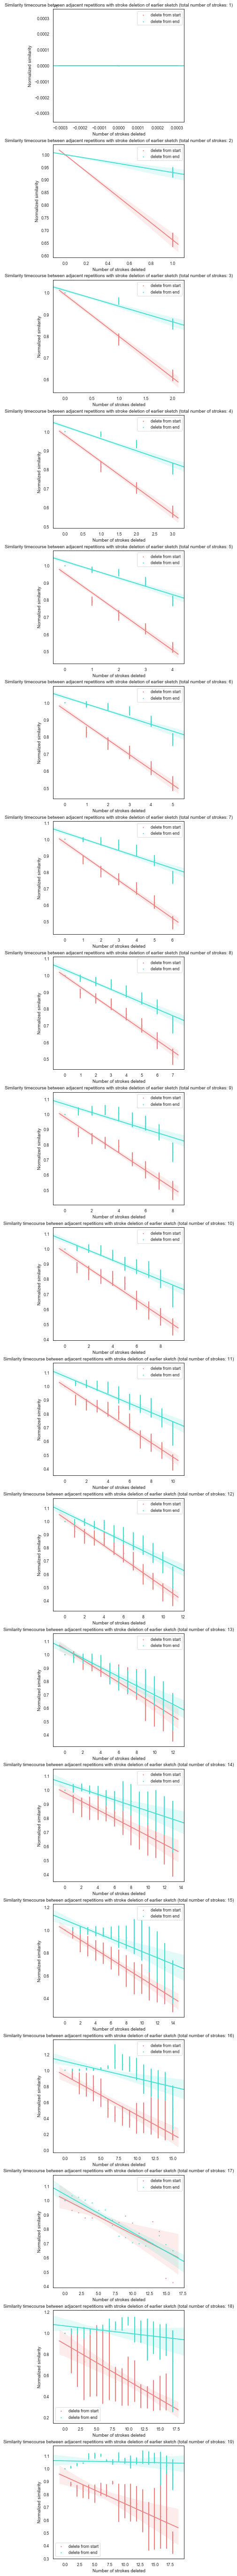

In [16]:
reload(h)
sns.set_context("paper")
h.plot_stroke_similarity_discrete(stroke_analysis_df, False)

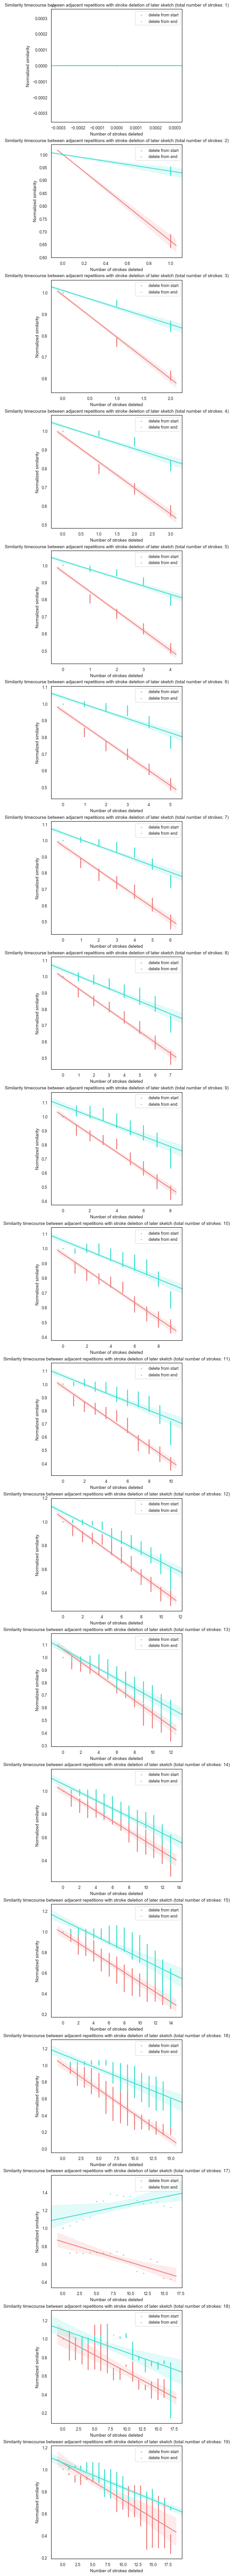

In [110]:
sns.set_context("paper")
h.plot_stroke_similarity_discrete(stroke_analysis_df, True)

#### exploratory analysis

In [196]:
# to do 
import PIL.Image
# first, find out median arclength of each trial of each game 
# then subset M_stroke_analysis such that there are only two rows per sketch (actually 4)
# to this new dataframe add another column that indicates first half or second half (according to arclength)
# try to do it with 70% ones only and then 30% only
def getArcLengths(svgListString):
    return [arcl(ast.literal_eval(svgListString)[i]) for i in range(len(ast.literal_eval(svgListString)))]

half_list = [None] * len(M_stroke_analysis)
M_stroke_analysis['half'] = half_list
M_stroke_analysis['exclude'] = half_list

for i,m in M_stroke_analysis.iterrows():
    g = m['gameID']
    t = m['trial_num']
    D_ = D[(D['gameID'] == g) & (D['trialNum'] == t)]
    svgListString = list(D_['svgString'])[0]
    arcLengths = getArcLengths(svgListString)
    totalArcLength = sum(arcLengths)
    halfArcLength = totalArcLength / 2.0 
    if arcLengths[0] > halfArcLength:
        M_stroke_analysis.ix[i, 'exclude'] = True 
        m['exclude'] = True
        if m['num_strokes_deleted'] == 1 and m['direction'] == 'start':
            M_stroke_analysis.ix[i, 'half'] = 'second'
        if m['num_strokes_deleted'] == len(ast.literal_eval(svgListString)) - 1 and m['direction'] == 'end':
            M_stroke_analysis.ix[i, 'half'] = 'first' 
        if m['num_strokes_deleted'] == 0 and m['direction'] == 'start':
            M_stroke_analysis.ix[i, 'half'] = 'full' 
    else:
        M_stroke_analysis.ix[i, 'exclude'] = False
        min_diff = float('inf')
        for j in range(len(arcLengths)):
            diff =abs(sum(arcLengths[:j+1]) - halfArcLength)
            if diff < min_diff:
                min_diff = diff
                strokes_in_first = j + 1
        if m['num_strokes_deleted'] == strokes_in_first and m['direction'] == 'start':
            M_stroke_analysis.ix[i, 'half'] = 'second'
        if m['num_strokes_deleted'] == len(ast.literal_eval(svgListString)) - strokes_in_first and m['direction'] == 'end':
            M_stroke_analysis.ix[i, 'half'] = 'first'
        if m['num_strokes_deleted'] == 0 and m['direction'] == 'start':
            M_stroke_analysis.ix[i, 'half'] = 'full' 

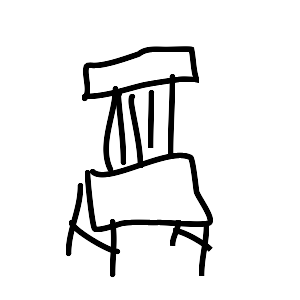

In [23]:
pngs_dir = os.path.join(sketch_dir, 'stroke_analysis/png')
trialNum = 12 
rep = 1 
direction = 'start'
num_strokes_deleted = 0
to_open = 'run3_0724-1a59371c-6fe6-4d6d-a987-db533e75a5e5_' + str(trialNum) + '_repeated_dining_04_' + str(rep) + '_' + str(direction) + '_' + str(num_strokes_deleted) + '.png'
image = PIL.Image.open(os.path.join(pngs_dir, to_open))
display(image) #image.show()

In [ ]:
def plot_stroke_similarity_rep_aggregate(d, lesion_later_sketch, ax):
    for direction in ['start', 'end']:
        d_ = d[(d['direction'] == direction) & (d['lesion_later_sketch'] == lesion_later_sketch)]
        color = 'lightcoral' if direction == 'start' else 'turquoise'
        label = 'delete from start' if direction == 'start' else 'delete from end'
        a = sns.regplot(x="percentage_strokes_deleted", y='similarity', data=d_, x_bins=10, ax=ax, color=color, label=label)
        later_or_earlier = "later" if lesion_later_sketch else "earlier"
        a.set_title('Similarity timecourse between adjacent repetitions with stroke deletion of {} sketch'.format(later_or_earlier))
        a.set_ylabel('Normalized similarity')
        a.set_xlabel('Percentage of strokes deleted')
        a.legend()

In [333]:
# M = M_half_valid

# sns.set_context("paper")
# fig, axs = plt.subplots(nrows=7, figsize=(5,35))
# #half_sketch_lesions_df = get_half_sketch_lesion_df(M_half_valid, F_stroke_analysis, axs)
F = F_stroke_analysis
M = M_half_invalid#M_stroke_analysis
# def get_half_sketch_lesion_df(M, F, axs):
d_invalid = pd.DataFrame()
for base_rep in range(7):
    next_rep = base_rep + 1 
    ax = axs[base_rep]
    for lesion_later_sketch in [True, False]:
        if lesion_later_sketch:
            deleted_rep = next_rep
            intact_rep = base_rep 
        else:
            deleted_rep = base_rep 
            intact_rep = next_rep 
        for direction in ['start', 'end']:
            for g in M['gameID'].unique():
                for t in M[(M['gameID'] == g) & (M['condition'] == 'repeated')]['target'].unique():
                    #if len(M_[(M['gameID'] == g) & (M['target'] == t) & (M['repetition'] == intact_rep) & (M['half'] == 'full')]) > 0:
                    try:
                        feature_ind_of_intact_sketch = M[(M['gameID'] == g) & (M['target'] == t) & (M['repetition'] == intact_rep) & (M['half'] == 'full')]['feature_ind'][0]
                    except:
                        print("oops")
                        continue  
                    for i in ['not_lesioned', 'lesioned']:
                        if (direction == 'start' and i == 'lesioned'):
                            half = 'second'
                        if (direction == 'end' and i == 'lesioned'):
                            half = 'first'
                        if (i == 'not_lesioned'):
                            half = 'full'
                        if len(M[(M['gameID'] == g) & (M['target'] == t) & (M['condition'] == 'repeated') & (M['repetition'] == next_rep) & (M['half'] == half)]) > 0:
                            feature_ind_of_deleted_sketch = M[(M['gameID'] == g) & (M['target'] == t) & (M['condition'] == 'repeated') & (M['repetition'] == next_rep) & (M['half'] == half)]['feature_ind'][0]
                        else:
                            continue
                        similarity = compute_similarity(F, [feature_ind_of_intact_sketch, feature_ind_of_deleted_sketch])
                        if i == 'not_lesioned':
                            baseline_similarity = similarity
                        normalized_similarity = float(similarity) / float(baseline_similarity)
                        lesioned = True if i == 'lesioned' else False
                        df_to_add = pd.DataFrame([[g, t, lesioned, normalized_similarity, base_rep, direction, lesion_later_sketch]], columns=['gameID', 'target', 'lesioned', 'similarity', 'base_rep', 'direction', 'lesion_later_sketch'])
                        d_invalid = d_invalid.append(df_to_add)

oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops


oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops


In [325]:
# combinations: lesion later sketch true false
def plot_half_lesion(d, lesion_later_sketch, ax):
    for direction in ['start', 'end']:
        d_ = d[(d['direction'] == direction) & (d['lesion_later_sketch'] == lesion_later_sketch)]
        color = 'lightcoral' if direction == 'start' else 'turquoise'
        label = 'delete first' if direction == 'start' else 'delete second'
        a = sns.regplot(x="lesioned", y='similarity', data=d_, x_bins=10, ax=ax, color=color, label=label)
        later_or_earlier = "later" if lesion_later_sketch else "earlier"
        a.set_title('Similarity between adjacent reps lesionin {} sketch'.format(later_or_earlier))
        a.set_ylabel('Normalized similarity')
#         a.set_xlabel('Percentage of strokes deleted')
        a.legend()
    
# combinations: lesion later sketch true false
def plot_half_lesion_rep(d, lesion_later_sketch, axs):
    for base_rep in range(7):
        next_rep = base_rep + 1
        ax=axs[base_rep]
        for direction in ['start', 'end']:
            d_ = d[(d['direction'] == direction) & (d['base_rep'] == base_rep) & (d['lesion_later_sketch'] == lesion_later_sketch)]
            color = 'lightcoral' if direction == 'start' else 'turquoise'
            intact = base_rep if lesion_later_sketch else next_rep
            lesioned = next_rep if lesion_later_sketch else base_rep
            label = 'delete first' if direction == 'start' else 'delete second'
            a = sns.regplot(x="lesioned", y='similarity', data=d_, x_bins=10, ax=ax, color=color, label=label)
            later_or_earlier = "later" if lesion_later_sketch else "earlier"
            a.set_title('intact: {} and lesioned: {}'.format(intact, lesioned))
            a.set_ylabel('Normalized similarity')
    #         a.set_xlabel('Percentage of strokes deleted')
            a.legend()

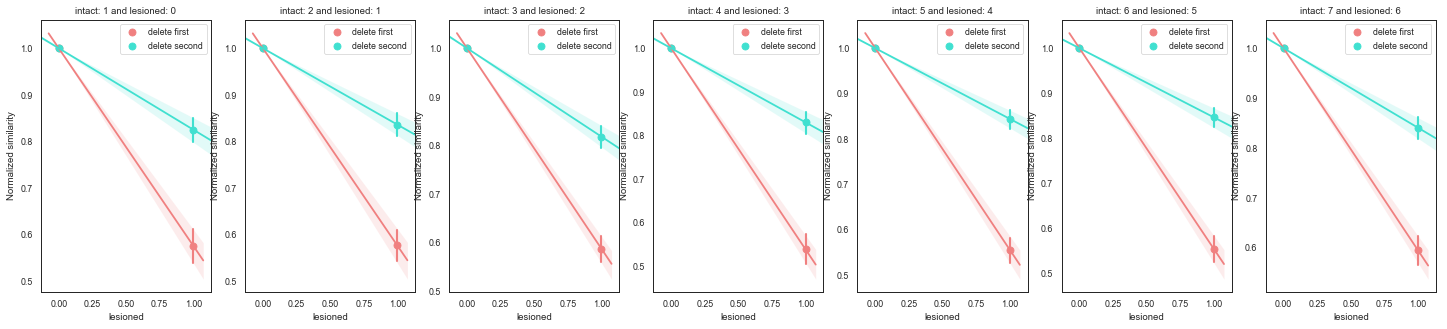

In [335]:
### invalid 30% version 
reload(h)
sns.set_context("paper")
fig, axs = plt.subplots(ncols=7, figsize=(25,5))
plot_half_lesion_rep(d_invalid, False, axs)

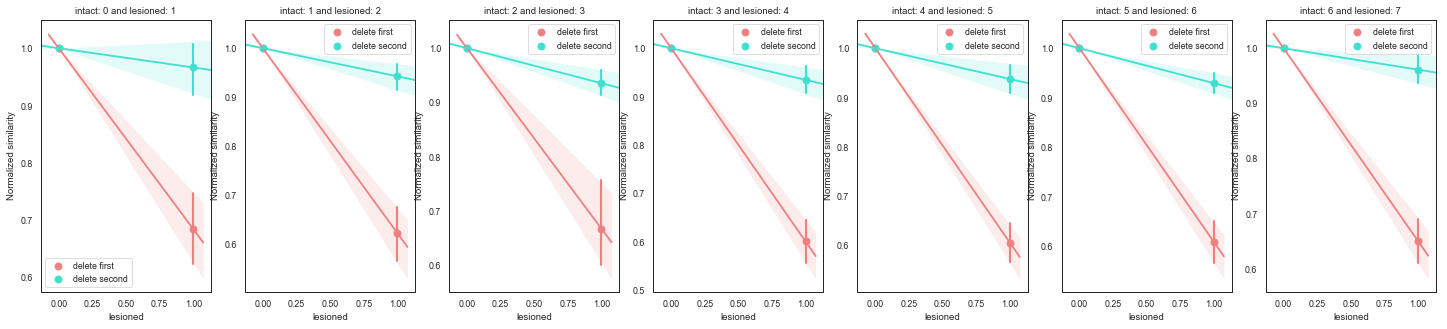

In [336]:
reload(h)
sns.set_context("paper")
fig, axs = plt.subplots(ncols=7, figsize=(25,5))
plot_half_lesion_rep(d_invalid, True, axs)

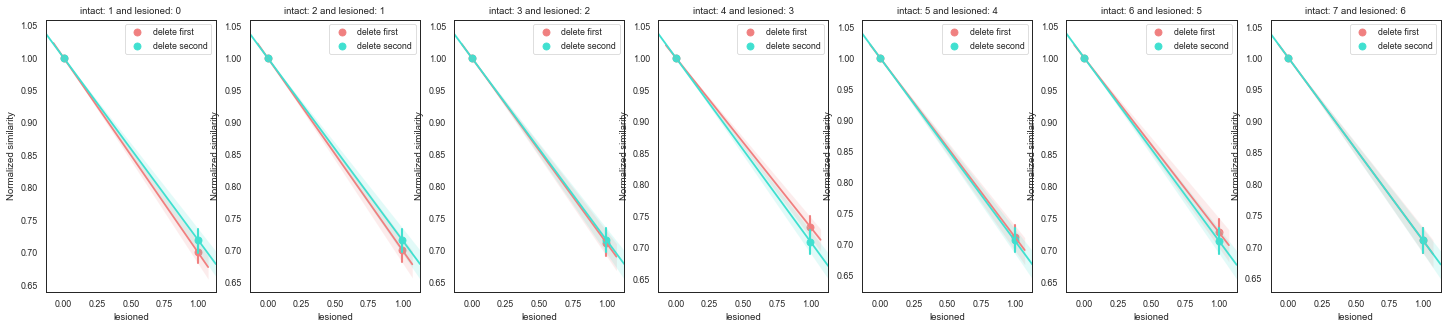

In [309]:
reload(h)
sns.set_context("paper")
fig, axs = plt.subplots(ncols=7, figsize=(25,5))
plot_half_lesion_rep(d, False, axs)

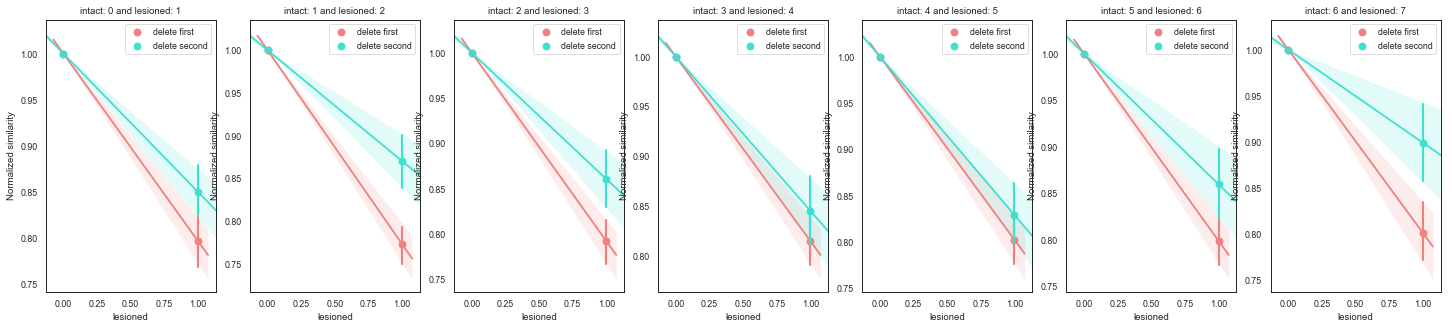

In [310]:
reload(h)
sns.set_context("paper")
fig, axs = plt.subplots(ncols=7, figsize=(25,5))
plot_half_lesion_rep(d, True, axs)

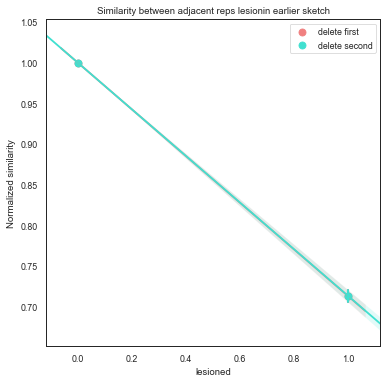

In [311]:
reload(h)
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(6, 6))
plot_half_lesion(d, False, ax)

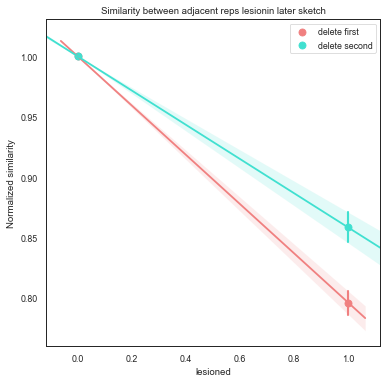

In [312]:
reload(h)
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(6, 6))
plot_half_lesion(d, True, ax)

In [180]:
count = 0 
difflist = []
total_arc_length_list = []
p = pd.DataFrame()
percentage_list = [] 
for i,d in D.iterrows():
    # what is the total arc length 
    arcLengths = getArcLengths(d['svgString'])
    totalArcLength = sum(arcLengths)
    total_arc_length_list.append(totalArcLength)
    if arcLengths[0] > totalArcLength / 2.0:
        diff = arcLengths[0] - totalArcLength / 2.0 
        difflist.append(diff)
    percentage = float(arcLengths[0]) / float(totalArcLength)
    percentage_list.append(percentage)
        
p['percentage'] = percentage_list

Text(0.5,0,'proportion of the first stroke in the sketch in terms of stroke length')

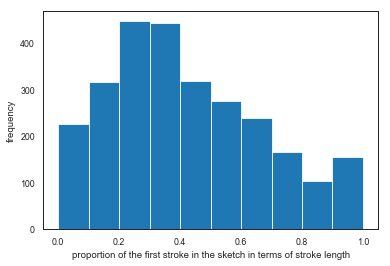

In [340]:
data = np.array(percentage_list)
plt.hist(data) 
plt.ylabel("frequency")
plt.xlabel("proportion of the first stroke in the sketch in terms of stroke length")

In [ ]:
### examining stroke length distribution 

In [141]:
from svgpathtools import parse_path
import svgpathtools
import math
import ast 

def arcl(svg):
    return parse_path(svg).length()

In [142]:
stroke_length_d = pd.DataFrame()
for i,d in D.iterrows():
    for stroke_num, path in enumerate(ast.literal_eval(d['svgString'])):
        length = math.log(arcl(path))
        df_to_add = pd.DataFrame([[stroke_num, length]], columns=['stroke_num', 'length'])
        stroke_length_d = stroke_length_d.append(df_to_add)    

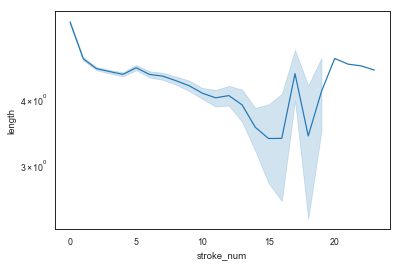

In [144]:
g = sns.lineplot(x="stroke_num", y="length", data=stroke_length_d)
g.set_yscale('log')
# g.set_yscale('log')